## Importing Libraries

In [317]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from shapely.geometry import shape, Point
import fiona as fi
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import requests
import re
from scipy.stats import nbinom
from zipfile import ZipFile
from io import BytesIO
import seaborn as sns
import networkx as nx
from collections import defaultdict

# Building COVID-19 Dataset

## Estimating Daily Number of Covid Exposures and Infectious Individuals
### Getting Raw Case Counts
The public covid case data provides multiple dates for each positive test: episode date, reported date, and specimen date. The episode date is the best estimate of when a subject first identifies syptoms. Since the World Health Organization claims that the Covid-19 incubation period (time from exposure to syptoms) is 5-6 days on average, we will select 5 days before the episode date as our estimate of exposure date. It is also estimated that individuals be infectious (contagious) from 1-2 days before onset until approximately 14 days from exposure, so we will assume that an individual is 'infectious' from 3 to 14 days after exposure.

In [319]:
raw_cases = pd.read_csv("conposcovidloc.csv")
raw_cases = raw_cases.loc[raw_cases['Accurate_Episode_Date'] > '2020-03-01']
raw_cases.head()

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-05-04,2020-05-13,2020-05-13,2020-05-07,50s,FEMALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-04-08,2020-04-17,2020-04-17,2020-04-10,50s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,3,2020-03-21,2020-04-04,2020-04-04,2020-04-02,50s,FEMALE,NO KNOWN EPI LINK,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,4,2020-05-13,2020-05-17,2020-05-17,2020-05-15,60s,MALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,5,2020-06-12,2020-06-15,2020-06-15,2020-06-14,20s,MALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893


In [350]:
phu_case_dates = raw_cases.loc[:,['Accurate_Episode_Date', 'Reporting_PHU_ID']]
phu_case_dates.rename(columns={"Reporting_PHU_ID": 'PHU_ID', 'Accurate_Episode_Date': "episode_date"}, inplace=True)
phu_case_dates['episode_date'] = pd.to_datetime(phu_case_dates['episode_date'])
phu_case_dates.head()

,episode_date,PHU_ID
0,2020-05-04,2253
1,2020-04-08,2253
2,2020-03-21,2253
3,2020-05-13,2253
4,2020-06-12,2253


In [365]:
cases_by_phu = phu_case_dates.groupby(['PHU_ID', 'episode_date']).agg(new_cases=('episode_date', 'count')).reset_index()
cases_by_phu.head()

,PHU_ID,episode_date,new_cases
0,2226,2020-03-08,1
1,2226,2020-03-15,1
2,2226,2020-03-20,2
3,2226,2020-03-22,2
4,2226,2020-03-23,2


### Removing Weekly Case Count Seasonality
Running a seasonal decompoisition on the Ontario-wide case counts by episode date, we can see that there is a significant weekly trend.

In [366]:
province_wide = cases_by_phu.reset_index().groupby('episode_date').sum()
province_wide.head()

,index,PHU_ID,new_cases
episode_date,,,
2020-03-02,36515,19647,15
2020-03-03,25895,12904,13
2020-03-04,39337,17436,14
2020-03-05,48829,26396,25
2020-03-06,57821,35355,34


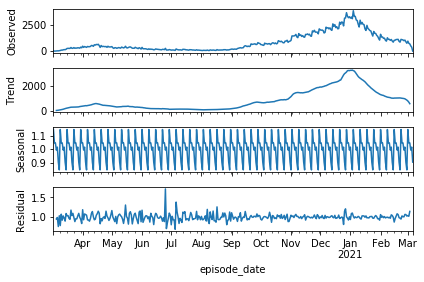

In [367]:
result = seasonal_decompose(province_wide.new_cases, model='multiplicative')
result.plot()
plt.show()

The concern with a weekly cases trend by episode date, is that it could be driven by inaccurate testing biases causing inaccurate episode date. According to the ontario goverment's data dictionary, the episode date field "uses a number of dates entered in the Integrated Public Health Information System (iPHIS) to provide an approximation of onset date". By removing the weekly seasonal component, we are left with a general trend and the residual error.

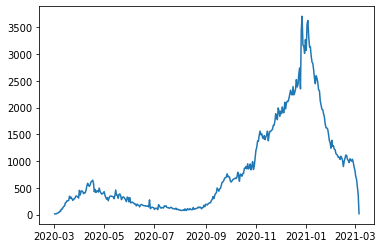

In [368]:
plt.plot(province_wide.new_cases / result.seasonal)

In [369]:
seasonal = pd.DataFrame({'seasonal_adjustment': result.seasonal}).reset_index()
seasonal.head()

,episode_date,seasonal_adjustment
0,2020-03-02,1.147785
1,2020-03-03,1.047020
2,2020-03-04,1.047316
3,2020-03-05,0.993674
4,2020-03-06,1.015744


In [1160]:
adjusted_cases_by_phu = cases_by_phu.merge(seasonal, on='episode_date')
adjusted_cases_by_phu['adjusted_new_cases'] = round(adjusted_cases_by_phu.new_cases / adjusted_cases_by_phu.seasonal_adjustment)
adjusted_cases_by_phu.head()

,PHU_ID,episode_date,new_cases,seasonal_adjustment,adjusted_new_cases
0,2226,2020-03-08,1,0.845091,1.0
1,2227,2020-03-08,2,0.845091,2.0
2,2230,2020-03-08,1,0.845091,1.0
3,2233,2020-03-08,3,0.845091,4.0
4,2235,2020-03-08,1,0.845091,1.0


### Estimating Exposure Date

Adding exposure date estimate based on 5 day syptom onset delay assumption

In [1161]:
adjusted_cases_by_phu['exposure_date'] = adjusted_cases_by_phu['episode_date'] - dt.timedelta(5)
adjusted_cases_by_phu.set_index(['PHU_ID', 'exposure_date'], inplace=True)
adjusted_cases_by_phu.head()

,,episode_date,new_cases,seasonal_adjustment,adjusted_new_cases
PHU_ID,exposure_date,,,,
2226,2020-03-03,2020-03-08,1,0.845091,1.0
2227,2020-03-03,2020-03-08,2,0.845091,2.0
2230,2020-03-03,2020-03-08,1,0.845091,1.0
2233,2020-03-03,2020-03-08,3,0.845091,4.0
2235,2020-03-03,2020-03-08,1,0.845091,1.0


We have a problem: for smaller PHU's, case numbers might be fairly low, and often there might not be positive cases on a specific date.  We can deal with this by creating a DataFrame with all PHU's and all dates.

In [1162]:
cases_by_phu_with_zeros = pd.DataFrame({'PHU_ID': phu_ids}).groupby('PHU_ID').apply(lambda x: pd.DataFrame({'date': adjusted_cases_by_phu.reset_index().exposure_date.unique()}).set_index('date')).reset_index()
cases_by_phu_with_zeros.set_index(['PHU_ID', 'date'], inplace=True)
cases_by_phu_with_zeros.sort_index(inplace=True)
cases_by_phu_with_zeros['new_cases'] = 0
cases_by_phu_with_zeros.head()

new_cases
PHU_ID date                 
2226   2020-02-26          0
       2020-02-27          0
       2020-02-28          0
       2020-02-29          0
       2020-03-01          0

In [1163]:
cases_by_phu_with_zeros.loc[adjusted_cases_by_phu.index, 'new_cases'] = adjusted_cases_by_phu['adjusted_new_cases']
cases_by_phu_with_zeros.head()

new_cases
PHU_ID date                 
2226   2020-02-26        0.0
       2020-02-27        0.0
       2020-02-28        0.0
       2020-02-29        0.0
       2020-03-01        0.0

Based on strong evidence that COVID-19 infectiousness begins [before syptom onset](https://www.nature.com/articles/s41591-020-0869-5), we make the assumption that infected individuals will become infectious 2 days before syptom onset (epsiode date), and 3 days after our estimated exposure date. We also make the conservative assumption that individuals will remain infectious until 14 days after exposure. Combining these two esimates, we get an infectious period from days 3-14.

In [1164]:
# This adds up new cases for 11 day period
total_infectious = pd.DataFrame({'total_infectious': cases_by_phu_with_zeros.reset_index().set_index('date').groupby('PHU_ID')['new_cases'].rolling(window=11).sum()}).dropna()
total_infectious.reset_index(inplace=True)
# Notice that we add 3 days to the exposure date so that date represents the 3 day delay until infectiousness we assume
total_infectious['date'] = total_infectious['date'] + dt.timedelta(3)
total_infectious.set_index(['PHU_ID', 'date'], inplace=True)
total_infectious.head()

total_infectious
PHU_ID date                        
2226   2020-03-10               1.0
       2020-03-11               1.0
       2020-03-12               1.0
       2020-03-13               2.0
       2020-03-14               2.0

We also want to estimate the number of resolved cases - that is, the number of people that will stop being infectious on a specific date.

In [1165]:
resolved_cases = cases_by_phu_with_zeros['new_cases'].reset_index()
# adding 14 days to exposure date to get cases coming out of infectious period
resolved_cases.date = resolved_cases.date + dt.timedelta(14)
resolved_cases.set_index(['PHU_ID', 'date'], inplace=True)
resolved_cases

new_cases
PHU_ID date                 
2226   2020-03-11        0.0
       2020-03-12        0.0
       2020-03-13        0.0
       2020-03-14        0.0
       2020-03-15        0.0
...                      ...
5183   2021-03-11        2.0
       2021-03-12        3.0
       2021-03-13        1.0
       2021-03-14        2.0
       2021-03-15        0.0

[12580 rows x 1 columns]

In [1167]:
cases_by_phu_with_zeros['total_infectious'] = total_infectious
cases_by_phu_with_zeros['resolved_cases'] = resolved_cases
cases_by_phu_with_zeros.dropna(inplace=True)
cases_by_phu_with_zeros.head()

new_cases  total_infectious  resolved_cases
PHU_ID date                                                   
2226   2020-03-11        0.0               1.0             0.0
       2020-03-12        0.0               1.0             0.0
       2020-03-13        0.0               2.0             0.0
       2020-03-14        0.0               2.0             0.0
       2020-03-15        2.0               2.0             0.0

## Getting COVID-19 Restrictions by Public Health Unit
Presumably covid restrictions (e.g. 'phase 1' or 'Lockdown' zone) and whether or not schools are open should have a significant impact on covid transmission in each Public Health Unit. Ontario has publicly available data identifying covid zone by public health unit from November 11, 2020 onward, but not before that. I manually created a dataset based on articles and public health statements tracking covid 'phases' and school closures from March 18th, 2020 onward.

Pulling in my custom dataset

In [388]:
restrictions_data = pd.read_csv('covid_phu_restrictions.csv').set_index(['PHU_NAME', 'Date'])
restrictions_data.head(5)

2020-03-17 2020-03-18 2020-03-19 2020-03-20 2020-03-21  \
PHU_NAME        Date                                                            
ALGOMA DISTRICT state     Phase 0    Phase 0    Phase 0    Phase 0    Phase 0   
                school          0          0          0          0          0   
BRANT COUNTY    state     Phase 0    Phase 0    Phase 0    Phase 0    Phase 0   
                school          0          0          0          0          0   
CHATHAM-KENT    state     Phase 0    Phase 0    Phase 0    Phase 0    Phase 0   

                       2020-03-22 2020-03-23 2020-03-24 2020-03-25 2020-03-26  \
PHU_NAME        Date                                                            
ALGOMA DISTRICT state     Phase 0    Phase 0    Phase 0    Phase 0    Phase 0   
                school          0          0          0          0          0   
BRANT COUNTY    state     Phase 0    Phase 0    Phase 0    Phase 0    Phase 0   
                school          0          0          0          0          0   
CHATHAM-KENT    state     Phase 0    Phase 0    Phase 0    Phase 0    Phase 0   

                        ... 2021-02-24 2021-02-25 2021-02-26 2021-02-27  \
PHU_NAME        Date    ...                                               
ALGOMA DISTRICT state   ...    Phase 3    Phase 3    Phase 3    Phase 3   
                school  ...          1          1          1          1   
BRANT COUNTY    state   ...    Phase 3    Phase 3    Phase 3    Phase 3   
                school  ...          1          1          1          1   
CHATHAM-KENT    state   ...    Phase 3    Phase 3    Phase 3    Phase 3   

                       2021-02-28 2021-03-01 2021-03-02 2021-03-03 2021-03-04  \
PHU_NAME        Date                                                            
ALGOMA DISTRICT state     Phase 3    Phase 3    Phase 3    Phase 3    Phase 3   
                school          1          1          1          1          1   
BRANT COUNTY    state     Phase 3    Phase 3    Phase 3    Phase 3    Phase 3   
                school          1          1          1          1          1   
CHATHAM-KENT    state     Phase 3    Phase 3    Phase 3    Phase 3    Phase 3   

                       2021-03-05  
PHU_NAME        Date               
ALGOMA DISTRICT state     Phase 3  
                school          1  
BRANT COUNTY    state     Phase 3  
                school          1  
CHATHAM-KENT    state     Phase 3  

[5 rows x 354 columns]

Creating DataFrame for every date and PHU

In [3]:
phu_id_names = pd.read_csv('phu_id_names.csv')
phu_id_names.head()

,PHU_ID,PHU_NAME
0,2226,ALGOMA DISTRICT
1,2227,BRANT COUNTY
2,2240,CHATHAM-KENT
3,2237,CITY OF HAMILTON
4,2251,CITY OF OTTAWA


In [4]:
phu_data = phu_id_names.groupby(['PHU_ID', 'PHU_NAME']).apply(lambda x: pd.DataFrame({'date': restrictions_data.columns.values}).set_index('date')).reset_index()
phu_data.head()

,PHU_ID,PHU_NAME,date
0,2226,ALGOMA DISTRICT,2020-03-17
1,2226,ALGOMA DISTRICT,2020-03-18
2,2226,ALGOMA DISTRICT,2020-03-19
3,2226,ALGOMA DISTRICT,2020-03-20
4,2226,ALGOMA DISTRICT,2020-03-21


Adding restrictions for specific Public Health Unit and Date

In [5]:
def get_restrictions(phu_name, date):
    state = restrictions_data.loc[(phu_name, 'state'), date]
    school = restrictions_data.loc[(phu_name, 'school'), date]
    return state, school

In [6]:
# restrictions state and school closure for each Public Health Unit and date
phu_data[['state', 'school']] = phu_data.apply(lambda x: get_restrictions(x.PHU_NAME, str(x.date)), 
                                               axis = 1, 
                                               result_type ='expand')
phu_data.date = pd.to_datetime(phu_data.date)
phu_data.set_index('PHU_ID', inplace=True)
phu_data.head(5)

,PHU_NAME,date,state,school
PHU_ID,,,,
2226,ALGOMA DISTRICT,2020-03-17,Phase 0,0
2226,ALGOMA DISTRICT,2020-03-18,Phase 0,0
2226,ALGOMA DISTRICT,2020-03-19,Phase 0,0
2226,ALGOMA DISTRICT,2020-03-20,Phase 0,0
2226,ALGOMA DISTRICT,2020-03-21,Phase 0,0


Splitting restritions data into before and after the adoption of 'Zones'

In [7]:
before_zones_phu_data = phu_data.loc[phu_data.date < dt.datetime(2020, 11, 7)]
after_zones_phu_data = phu_data.loc[phu_data.date >= dt.datetime(2020, 11, 7)]

### Joining my Dataset with Ontario's Published Zones Dataset
We can join this data with the published zone data to get a dataset with school closure data and covid restriction state by Public Health Unit for March 18th, 2020 to March 8th, 2021.

Pulling in ontario's published response framework zones data

In [8]:
zones = pd.read_csv('response_framework.csv').set_index('Reporting_PHU_id')
zones.head()

,Reporting_PHU,Status_PHU,start_date,end_date,PHU_url
Reporting_PHU_id,,,,,
2226,Algoma Public Health Unit,Prevent,2020-11-07T00:00:00,2020-12-25T00:00:00,http://www.algomapublichealth.com/
2226,Algoma Public Health Unit,Stay-at-home,2020-12-26T00:00:00,2021-02-15T00:00:00,http://www.algomapublichealth.com/
2226,Algoma Public Health Unit,Protect,2021-02-16T00:00:00,2021-03-14T00:00:00,http://www.algomapublichealth.com/
2227,Brant County Health Unit,Protect,2020-11-07T00:00:00,2020-11-15T00:00:00,http://www.bchu.org/
2227,Brant County Health Unit,Restrict,2020-11-16T00:00:00,2020-12-20T00:00:00,http://www.bchu.org/


Cleaning up dataframe

In [9]:
# dropping columns
zones.drop(['Reporting_PHU', 'PHU_url'], axis=1, inplace=True)
# converting to datetime
zones['start_date'] = pd.to_datetime(zones['start_date'], format ='%Y-%m-%d %H:%M:%S')
zones['end_date'] = pd.to_datetime(zones['end_date'], format ='%Y-%m-%d %H:%M:%S')
zones.head()

,Status_PHU,start_date,end_date
Reporting_PHU_id,,,
2226,Prevent,2020-11-07,2020-12-25
2226,Stay-at-home,2020-12-26,2021-02-15
2226,Protect,2021-02-16,2021-03-14
2227,Protect,2020-11-07,2020-11-15
2227,Restrict,2020-11-16,2020-12-20


Joining the ontario zones dataset with my restrictions dataset

In [10]:
after_zones_phu_data = after_zones_phu_data.merge(zones, how='inner', left_index=True, right_index=True)
# filtering to only include the zone of the time period the date is part of
after_zones_phu_data = after_zones_phu_data.loc[(after_zones_phu_data.date >= after_zones_phu_data.start_date) & (after_zones_phu_data.date <= after_zones_phu_data.end_date)]
after_zones_phu_data.head()

,PHU_NAME,date,state,school,Status_PHU,start_date,end_date
2226,ALGOMA DISTRICT,2020-11-07,Phase 3,1,Prevent,2020-11-07,2020-12-25
2226,ALGOMA DISTRICT,2020-11-08,Phase 3,1,Prevent,2020-11-07,2020-12-25
2226,ALGOMA DISTRICT,2020-11-09,Phase 3,1,Prevent,2020-11-07,2020-12-25
2226,ALGOMA DISTRICT,2020-11-10,Phase 3,1,Prevent,2020-11-07,2020-12-25
2226,ALGOMA DISTRICT,2020-11-11,Phase 3,1,Prevent,2020-11-07,2020-12-25


In [11]:
after_zones_phu_data['state'] = after_zones_phu_data['Status_PHU']
after_zones_phu_data.drop(['start_date', 'end_date', 'Status_PHU'], axis=1, inplace=True)
after_zones_phu_data.head()

,PHU_NAME,date,state,school
2226,ALGOMA DISTRICT,2020-11-07,Prevent,1
2226,ALGOMA DISTRICT,2020-11-08,Prevent,1
2226,ALGOMA DISTRICT,2020-11-09,Prevent,1
2226,ALGOMA DISTRICT,2020-11-10,Prevent,1
2226,ALGOMA DISTRICT,2020-11-11,Prevent,1


In [300]:
phu_data = before_zones_phu_data.append(after_zones_phu_data, sort=False)
phu_data.index.name = 'PHU_ID'
phu_data.set_index('date', append=True, inplace=True)
phu_data.head()

PHU_NAME    state school
PHU_ID date                                       
2226   2020-03-17  ALGOMA DISTRICT  Phase 0      0
       2020-03-18  ALGOMA DISTRICT  Phase 0      0
       2020-03-19  ALGOMA DISTRICT  Phase 0      0
       2020-03-20  ALGOMA DISTRICT  Phase 0      0
       2020-03-21  ALGOMA DISTRICT  Phase 0      0

Converting restrictions state discrete features into several binary features

In [301]:
state_dummies = pd.get_dummies(phu_data.state)
state_dummies.head()

Control  Lockdown  Other  Phase 0  Phase 1  Phase 2  \
PHU_ID date                                                              
2226   2020-03-17        0         0      0        1        0        0   
       2020-03-18        0         0      0        1        0        0   
       2020-03-19        0         0      0        1        0        0   
       2020-03-20        0         0      0        1        0        0   
       2020-03-21        0         0      0        1        0        0   

                   Phase 3  Prevent  Protect  Restrict  Stay-at-home  
PHU_ID date                                                           
2226   2020-03-17        0        0        0         0             0  
       2020-03-18        0        0        0         0             0  
       2020-03-19        0        0        0         0             0  
       2020-03-20        0        0        0         0             0  
       2020-03-21        0        0        0         0             0

Converting state binary features into 7 day rolling average to account for the delayed transition from one restriction state to another

In [302]:
state_dummies = state_dummies.reset_index().set_index('date').groupby('PHU_ID').rolling(7).mean().shift(-6).drop('PHU_ID', axis=1).dropna()
state_dummies.head()

Control  Lockdown  Other  Phase 0  Phase 1  Phase 2  \
PHU_ID date                                                              
2226   2020-03-17      0.0       0.0    0.0      1.0      0.0      0.0   
       2020-03-18      0.0       0.0    0.0      1.0      0.0      0.0   
       2020-03-19      0.0       0.0    0.0      1.0      0.0      0.0   
       2020-03-20      0.0       0.0    0.0      1.0      0.0      0.0   
       2020-03-21      0.0       0.0    0.0      1.0      0.0      0.0   

                   Phase 3  Prevent  Protect  Restrict  Stay-at-home  
PHU_ID date                                                           
2226   2020-03-17      0.0      0.0      0.0       0.0           0.0  
       2020-03-18      0.0      0.0      0.0       0.0           0.0  
       2020-03-19      0.0      0.0      0.0       0.0           0.0  
       2020-03-20      0.0      0.0      0.0       0.0           0.0  
       2020-03-21      0.0      0.0      0.0       0.0           0.0

Merging binary restriction state features back into dataset

In [303]:
# phu_data.drop('state', axis=1, inplace=True)
phu_data = phu_data.merge(state_dummies, left_index=True, right_index=True)
phu_data.head()

,,PHU_NAME,state,school,Control,Lockdown,Other,Phase 0,Phase 1,Phase 2,Phase 3,Prevent,Protect,Restrict,Stay-at-home
PHU_ID,date,,,,,,,,,,,,,,
2265,2021-01-15,WATERLOO REGION,Stay-at-home,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2251,2020-09-27,CITY OF OTTAWA,Phase 3,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2265,2020-08-12,WATERLOO REGION,Phase 3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2241,2020-05-23,"KINGSTON, FRONTENAC, LENNOX & ADDINGTON",Phase 1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2244,2020-05-05,MIDDLESEX-LONDON,Phase 0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Finding Other Regional and Seasonal Transmission Factors

## Public Health Unit Boundaries
In order to aggregate various geographical statistics by Public Health Unit (PHU), we need the PHU geographic boundaries. Fortunately, the ontario government provides shape files of the PHU boundaries [here](https://geohub.lio.gov.on.ca/datasets/c2fa5249b0c2404ea8132c051d934224_0?geometry=-168.465%2C38.920%2C-1.034%2C58.787). We use the **fiona** Python library to read the shape files, and the **shapely** Python library to interact with the boundaries.

In [16]:
phu_shapes = fi.open('phu_boundaries/phu.shp')

Here we use a dictionary to map Public Health Unit (PHU) ID to its boundary shape

In [17]:
phu_dict = {phu['properties']['PHU_ID']: shape(phu['geometry']) for phu in phu_shapes}

To ensure that we've formatted our PHU shapes correctly, we can plot them to check that they cover Ontario

In [18]:
def plot_shapes(shapes):
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    cm = plt.get_cmap('RdBu')
    for i, shape in enumerate(shapes):
        colour = cm(1. * i / len(shapes))
        if shape.geom_type == 'Polygon':
            geoms = [shape]
        else:
            geoms = shape.geoms
        for geom in geoms:
            xs, ys = geom.exterior.xy    
            ax.fill(xs, ys, alpha=0.5, fc=colour, ec='none')
    plt.show()

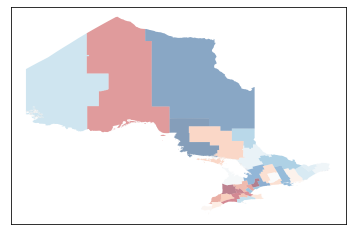

In [19]:
plot_shapes(phu_dict.values())

In [20]:
phu_ids = list(phu_dict.keys())

## Census Data by Public Health Unit

In order to account for regional (for each Public Health Unit) differences in COVID-19 transmission, we can aggregate some census statistics across each Public Health Unit.

### Getting 2016 Ontario Census Data

We can pull 2016 census data for Ontario by Census Subdivision. This gives us a large dataset where each row represents one statistic for one census subdivision.

In [21]:
census_url = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/download-telecharger/comp/GetFile.cfm?Lang=E&FILETYPE=CSV&GEONO=066'

In [22]:
download_request = requests.get(census_url)
zip_file = ZipFile(BytesIO(download_request.content))
files = zip_file.namelist()
with zip_file.open(files[0], 'r') as csvfile:
    census_raw = pd.read_csv(csvfile)
census_raw.head()

,CENSUS_YEAR,GEO_CODE (POR),GEO_LEVEL,GEO_NAME,GNR,GNR_LF,DATA_QUALITY_FLAG,CSD_TYPE_NAME,ALT_GEO_CODE,DIM: Profile of Census Subdivisions (2247),Member ID: Profile of Census Subdivisions (2247),Notes: Profile of Census Subdivisions (2247),Dim: Sex (3): Member ID: [1]: Total - Sex,Dim: Sex (3): Member ID: [2]: Male,Dim: Sex (3): Member ID: [3]: Female
0,2016,3501005,1,South Glengarry,3.9,2.7,0,TP,3501005,"Population, 2016",1,1.0,13150.00,...,...
1,2016,3501005,1,South Glengarry,3.9,2.7,0,TP,3501005,"Population, 2011",2,2.0,13162.00,...,...
2,2016,3501005,1,South Glengarry,3.9,2.7,0,TP,3501005,"Population percentage change, 2011 to 2016",3,NaN,-0.10,...,...
3,2016,3501005,1,South Glengarry,3.9,2.7,0,TP,3501005,Total private dwellings,4,3.0,5823.00,...,...
4,2016,3501005,1,South Glengarry,3.9,2.7,0,TP,3501005,Private dwellings occupied by usual residents,5,4.0,5300.00,...,...


From this dataset, we only really need the geocode (which maps to a census subdivision), the name of each statistic, and the value of each statistic for both sexes combined (since there is no reason to believe that there are any sex imbalances across Public Health Units that would contribute to any meaningfull regional differences).

In [23]:
rename_mapping = {'GEO_CODE (POR)': 'geo_code', 'Dim: Sex (3): Member ID: [1]: Total - Sex': 'value', 'DIM: Profile of Census Subdivisions (2247)': 'stat'}
census = census_raw[rename_mapping.keys()].rename(columns = rename_mapping)
census.head()

,geo_code,value,stat
0,3501005,13150.00,"Population, 2016"
1,3501005,13162.00,"Population, 2011"
2,3501005,-0.10,"Population percentage change, 2011 to 2016"
3,3501005,5823.00,Total private dwellings
4,3501005,5300.00,Private dwellings occupied by usual residents


Since every stat value should be float, we convert the value column to type float and replace non-numeric values with numpy nan values

In [24]:
census.value = census.value.str.extract('(\d+)').astype('float')

Now, we can remove nan values

In [25]:
census.dropna(inplace=True)
census.head()

,geo_code,value,stat
0,3501005,13150.0,"Population, 2016"
1,3501005,13162.0,"Population, 2011"
2,3501005,0.0,"Population percentage change, 2011 to 2016"
3,3501005,5823.0,Total private dwellings
4,3501005,5300.0,Private dwellings occupied by usual residents


### Census Subdivision Boundaries
In order to aggregate census data by Public Health Unit (PHU), we need to figure out which census Subdivisions are in which Public Health Units (PHU). Fortunately, Canadian census subdivision boundary shape files can be found [here](https://public.opendatasoft.com/explore/dataset/georef-canada-census-subdivision-millesime/table/?disjunctive.csd_name_en&sort=year). We use the **fiona** Python library to read the shape files, and the **shapely** Python library to interact with the boundaries.

In [1189]:
subdivision_url = 'https://public.opendatasoft.com/explore/dataset/georef-canada-census-subdivision-millesime/download/?format=shp&timezone=America/New_York&lang=en'

In [ ]:
download_response = requests.get(subdivision_url)

In [ ]:
zip_file = ZipFile(BytesIO(download_response.content))
zip_file.extractall('census_subdivision_boundaries')

In [1191]:
csd_shapes = fi.open('census_subdivision_boundaries/georef-canada-census-subdivision-millesime.shp')

From our census dataset, we can get the set of geocodes associated with Ontario subdivisions to filter out all the non-Ontario subdivisions.

In [27]:
geo_codes = set(census.geo_code.unique())

Here we use a dictionary to map Ontario census subdivision geocodes to their corresponding boundary shapes

In [28]:
csd_dict = {int(csd['properties']['csd_code']): shape(csd['geometry']) for csd in csd_shapes if (int(csd['properties']['csd_code']) in geo_codes)}

To ensure that we've formatted our PHU shapes correctly, we can plot them to check that they cover Ontario

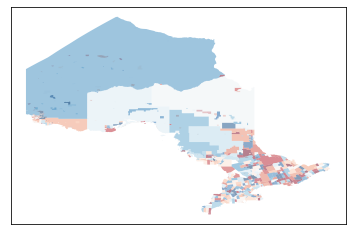

In [29]:
plot_shapes(csd_dict.values())

### Mapping Census Subdivision to Public Health Unit
We can map census subdivisions to Public Health Unit (PHU) by checking to see which census subdivisions have most of their land area within a PHU

In [30]:
def mostly_in(csd, phu):
    csd_area = csd.area
    inter_area = phu.intersection(csd).area
    return (inter_area / csd_area) > 0.5

We create a dictionary mapping PHU to census subdivision iteratively, removing subdivisions once we've found its corresponding PHU

In [31]:
csd_phu_dict = {}
csd_set = set(csd_dict.keys())
for phu_id, phu in phu_dict.items():
    for geo_code in csd_set.copy():
        csd = csd_dict[geo_code]
        if mostly_in(csd, phu):
            csd_phu_dict[geo_code] = phu_id
            csd_set.remove(geo_code)

We can plot a PHU and its associated census subdivisions to illustrate this mapping

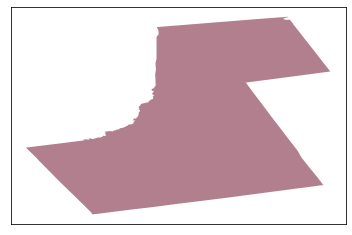

In [32]:
plot_shapes([phu_dict[2270]])

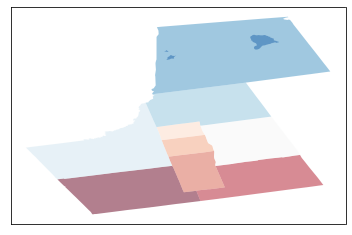

In [33]:
plot_shapes([csd_dict[geo_code] for geo_code in csd_phu_dict.keys() if csd_phu_dict[geo_code] == 2270])

### Adding Public Health Unit to Census Data

In [34]:
csd_phu_df = pd.DataFrame(csd_phu_dict.items(), columns=['geo_code', 'PHU_ID'])
csd_phu_df.head()

,geo_code,PHU_ID
0,3519028,2270
1,3519036,2270
2,3519038,2270
3,3519046,2270
4,3519048,2270


In [35]:
census = census.merge(csd_phu_df, on='geo_code')
census.head()

,geo_code,value,stat,PHU_ID
0,3501005,13150.0,"Population, 2016",2258
1,3501005,13162.0,"Population, 2011",2258
2,3501005,0.0,"Population percentage change, 2011 to 2016",2258
3,3501005,5823.0,Total private dwellings,2258
4,3501005,5300.0,Private dwellings occupied by usual residents,2258


### Aggregating Census Data

From the available stats in the census data, we identify potential factors that could account for regional differences in COVID-19 transmission.

In [36]:
counts = ['Single-detached house',
         'Postsecondary certificate, diploma or degree',
         'Immigrants',
         'Under $5,000',
         '$10,000 to $14,999',
         '$15,000 to $19,999',
         '$20,000 to $24,999',
         '$25,000 to $29,999',
         '$30,000 to $34,999',
        '0 to 14 years',
        '15 to 19 years',
        '20 to 24 years',
        '25 to 29 years',
        '30 to 34 years',
        '35 to 39 years',
        '40 to 44 years',
        '45 to 49 years',
        '50 to 54 years',
        '55 to 59 years',
        '60 to 64 years',
        '65 to 69 years',
        '70 to 74 years',
        '75 to 79 years',
        '80 to 84 years',
        '85 to 89 years',
        '90 to 94 years',
        '95 to 99 years',
         'Land area in square kilometres']

In [37]:
rates = ['Average age of the population',
         'Median age of the population',
         'Average household size',
         'Average size of census families',
         'Average after-tax income in 2015 among recipients ($)',
         'Median total income of households in 2015 ($)',
         'Median value of dwellings ($)',
         'Average value of dwellings ($)',
         'Median monthly shelter costs for rented dwellings ($)',
         'Average monthly shelter costs for rented dwellings ($)',
         'Unemployment rate']

In [38]:
potential_factors = counts + rates + ['Population, 2016']

In [39]:
filtered_census = census.merge(pd.DataFrame({'stat': potential_factors}))
filtered_census.head()

,geo_code,value,stat,PHU_ID
0,3501005,13150.0,"Population, 2016",2258
1,3501007,1487.0,"Population, 2016",2258
2,3501011,13110.0,"Population, 2016",2258
3,3501012,46589.0,"Population, 2016",2258
4,3501020,10833.0,"Population, 2016",2258


In [40]:
pivoted_census = pd.pivot_table(filtered_census, values='value', index=['PHU_ID', 'geo_code'],
                    columns=['stat'], aggfunc=np.max).reset_index()
pivoted_census.columns.name = None
pivoted_census.head()

,PHU_ID,geo_code,"$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999",0 to 14 years,15 to 19 years,20 to 24 years,...,Land area in square kilometres,Median age of the population,Median monthly shelter costs for rented dwellings ($),Median total income of households in 2015 ($),Median value of dwellings ($),"Population, 2016","Postsecondary certificate, diploma or degree",Single-detached house,"Under $5,000",Unemployment rate
0,2226,3557001,0.0,5.0,5.0,5.0,20.0,20.0,10.0,5.0,...,131.0,60.0,0.0,62272.0,200547.0,313.0,185.0,155.0,0.0,9.0
1,2226,3557004,5.0,5.0,5.0,5.0,10.0,35.0,10.0,15.0,...,115.0,58.0,0.0,68864.0,251462.0,307.0,185.0,135.0,5.0,0.0
2,2226,3557006,NaN,NaN,NaN,NaN,NaN,20.0,5.0,5.0,...,2.0,53.0,0.0,41984.0,188428.0,171.0,85.0,75.0,NaN,12.0
3,2226,3557008,5.0,20.0,25.0,15.0,25.0,140.0,55.0,55.0,...,129.0,56.0,0.0,71270.0,234639.0,1240.0,615.0,530.0,10.0,8.0
4,2226,3557011,10.0,5.0,10.0,10.0,20.0,160.0,45.0,50.0,...,102.0,48.0,0.0,87680.0,249916.0,1047.0,485.0,425.0,0.0,8.0


Adjusting count statistics to be per capita rates

In [41]:
pivoted_census.loc[:, counts] = pivoted_census.apply(lambda x: x[counts] / x['Population, 2016'], axis=1)

In [42]:
pivoted_census.head()

,PHU_ID,geo_code,"$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999",0 to 14 years,15 to 19 years,20 to 24 years,...,Land area in square kilometres,Median age of the population,Median monthly shelter costs for rented dwellings ($),Median total income of households in 2015 ($),Median value of dwellings ($),"Population, 2016","Postsecondary certificate, diploma or degree",Single-detached house,"Under $5,000",Unemployment rate
0,2226,3557001,0.000000,0.015974,0.015974,0.015974,0.063898,0.063898,0.031949,0.015974,...,0.418530,60.0,0.0,62272.0,200547.0,313.0,0.591054,0.495208,0.000000,9.0
1,2226,3557004,0.016287,0.016287,0.016287,0.016287,0.032573,0.114007,0.032573,0.048860,...,0.374593,58.0,0.0,68864.0,251462.0,307.0,0.602606,0.439739,0.016287,0.0
2,2226,3557006,NaN,NaN,NaN,NaN,NaN,0.116959,0.029240,0.029240,...,0.011696,53.0,0.0,41984.0,188428.0,171.0,0.497076,0.438596,NaN,12.0
3,2226,3557008,0.004032,0.016129,0.020161,0.012097,0.020161,0.112903,0.044355,0.044355,...,0.104032,56.0,0.0,71270.0,234639.0,1240.0,0.495968,0.427419,0.008065,8.0
4,2226,3557011,0.009551,0.004776,0.009551,0.009551,0.019102,0.152818,0.042980,0.047755,...,0.097421,48.0,0.0,87680.0,249916.0,1047.0,0.463228,0.405922,0.000000,8.0


Grouping by PHU and taking a population weighted average

In [43]:
def pop_weighted_average(df):
    df.loc[:, counts + rates] = df.apply(lambda x: x[counts + rates] * x['Population, 2016'], axis=1)
    grouped = df.sum()
    grouped[counts + rates] = grouped[counts + rates] / grouped['Population, 2016']
    return grouped[counts + rates + ['Population, 2016']]

In [527]:
phu_census = pivoted_census.groupby('PHU_ID').apply(pop_weighted_average)
phu_census.head()

,Single-detached house,"Postsecondary certificate, diploma or degree",Immigrants,"Under $5,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999",0 to 14 years,...,Average household size,Average size of census families,Average after-tax income in 2015 among recipients ($),Median total income of households in 2015 ($),Median value of dwellings ($),Average value of dwellings ($),Median monthly shelter costs for rented dwellings ($),Average monthly shelter costs for rented dwellings ($),Unemployment rate,"Population, 2016"
PHU_ID,,,,,,,,,,,,,,,,,,,,,
2226,0.304363,0.421755,0.079088,0.005633,0.018206,0.022712,0.030508,0.023749,0.027084,0.141186,...,1.900958,2.034231,34822.154128,59402.635684,178265.444359,208018.124548,683.891441,716.824034,10.050138,110953.0
2227,0.260888,0.387386,0.122052,0.003853,0.010856,0.014858,0.020601,0.017859,0.020453,0.175148,...,1.991033,1.991033,35741.995917,69846.114152,307585.678850,332674.215128,894.716317,924.466901,5.476935,134943.0
2230,0.235677,0.436726,0.233595,0.003205,0.005884,0.008167,0.011024,0.010761,0.012201,0.179899,...,2.185298,2.701410,40296.935231,91342.471553,460630.252189,502575.296071,1132.001406,1177.100930,7.651187,645862.0
2233,0.335585,0.418444,0.076340,0.005697,0.012090,0.017756,0.022978,0.019718,0.023358,0.154009,...,2.000000,2.088835,37556.877939,67956.839908,277813.466438,327514.518104,827.508659,865.056337,5.659991,157978.0
2234,0.332598,0.381160,0.096122,0.004195,0.008846,0.014637,0.019060,0.016324,0.019744,0.158912,...,2.000000,2.000000,35651.449385,70989.484989,271423.062744,313796.845365,834.398351,856.132966,6.584066,109652.0


Grouping age ranges into phases of life

In [528]:
phu_census['children'] = phu_census['0 to 14 years']
phu_census['teens'] = phu_census['15 to 19 years']
phu_census['young_adults'] = phu_census[['20 to 24 years', '25 to 29 years']].sum(axis=1)
phu_census['middle_aged_adults'] = phu_census[['30 to 34 years', '35 to 39 years','40 to 44 years', '45 to 49 years']].sum(axis=1)
phu_census['older_adults'] = phu_census[['50 to 54 years', '55 to 59 years', '60 to 64 years']].sum(axis=1)
phu_census['seniors'] =  phu_census[['65 to 69 years', '70 to 74 years', '75 to 79 years', 
                                     '80 to 84 years', '85 to 89 years', '90 to 94 years', '95 to 99 years']].sum(axis=1)

Removing specific age stats

In [529]:
age_stats = ['0 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 29 years',
             '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years',
             '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 69 years',
             '70 to 74 years', '75 to 79 years', '80 to 84 years', '85 to 89 years',
             '90 to 94 years', '95 to 99 years']

In [530]:
phu_census.drop(age_stats, axis=1, inplace=True)
phu_census.head()

,Single-detached house,"Postsecondary certificate, diploma or degree",Immigrants,"Under $5,000","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999","$25,000 to $29,999","$30,000 to $34,999",Land area in square kilometres,...,Median monthly shelter costs for rented dwellings ($),Average monthly shelter costs for rented dwellings ($),Unemployment rate,"Population, 2016",children,teens,young_adults,middle_aged_adults,older_adults,seniors
PHU_ID,,,,,,,,,,,,,,,,,,,,,
2226,0.304363,0.421755,0.079088,0.005633,0.018206,0.022712,0.030508,0.023749,0.027084,0.431138,...,683.891441,716.824034,10.050138,110953.0,0.141186,0.050066,0.109100,0.213829,0.249971,0.235415
2227,0.260888,0.387386,0.122052,0.003853,0.010856,0.014858,0.020601,0.017859,0.020453,0.006966,...,894.716317,924.466901,5.476935,134943.0,0.175148,0.060581,0.116790,0.249068,0.218648,0.175037
2230,0.235677,0.436726,0.233595,0.003205,0.005884,0.008167,0.011024,0.010761,0.012201,0.003900,...,1132.001406,1177.100930,7.651187,645862.0,0.179899,0.066523,0.125127,0.265575,0.219203,0.143498
2233,0.335585,0.418444,0.076340,0.005697,0.012090,0.017756,0.022978,0.019718,0.023358,0.049412,...,827.508659,865.056337,5.659991,157978.0,0.154009,0.053583,0.101533,0.208004,0.247851,0.234906
2234,0.332598,0.381160,0.096122,0.004195,0.008846,0.014637,0.019060,0.016324,0.019744,0.026064,...,834.398351,856.132966,6.584066,109652.0,0.158912,0.059826,0.108343,0.218053,0.248149,0.206563


Grouping low income brackets

In [531]:
low_income = ['Under $5,000', '$10,000 to $14,999',
       '$15,000 to $19,999', '$20,000 to $24,999', '$25,000 to $29,999',
       '$30,000 to $34,999']

In [532]:
phu_census['under_35k'] = phu_census[low_income].sum(axis=1)

Dropping specific low income brackets

In [533]:
phu_census.drop(low_income, axis=1, inplace=True)
phu_census.head()

,Single-detached house,"Postsecondary certificate, diploma or degree",Immigrants,Land area in square kilometres,Average age of the population,Median age of the population,Average household size,Average size of census families,Average after-tax income in 2015 among recipients ($),Median total income of households in 2015 ($),...,Average monthly shelter costs for rented dwellings ($),Unemployment rate,"Population, 2016",children,teens,young_adults,middle_aged_adults,older_adults,seniors,under_35k
PHU_ID,,,,,,,,,,,,,,,,,,,,,
2226,0.304363,0.421755,0.079088,0.431138,44.867881,47.722901,1.900958,2.034231,34822.154128,59402.635684,...,716.824034,10.050138,110953.0,0.141186,0.050066,0.109100,0.213829,0.249971,0.235415,0.127892
2227,0.260888,0.387386,0.122052,0.006966,40.364702,40.909740,1.991033,1.991033,35741.995917,69846.114152,...,924.466901,5.476935,134943.0,0.175148,0.060581,0.116790,0.249068,0.218648,0.175037,0.088482
2230,0.235677,0.436726,0.233595,0.003900,39.014358,40.063882,2.185298,2.701410,40296.935231,91342.471553,...,1177.100930,7.651187,645862.0,0.179899,0.066523,0.125127,0.265575,0.219203,0.143498,0.051242
2233,0.335585,0.418444,0.076340,0.049412,44.409152,47.726462,2.000000,2.088835,37556.877939,67956.839908,...,865.056337,5.659991,157978.0,0.154009,0.053583,0.101533,0.208004,0.247851,0.234906,0.101596
2234,0.332598,0.381160,0.096122,0.026064,43.168132,45.752198,2.000000,2.000000,35651.449385,70989.484989,...,856.132966,6.584066,109652.0,0.158912,0.059826,0.108343,0.218053,0.248149,0.206563,0.082807


Converting land area per capita to population density

In [534]:
phu_census['population_density'] = 1 / phu_census['Land area in square kilometres']

In [535]:
phu_census.drop(['Population, 2016', 'Land area in square kilometres'], axis=1, inplace=True)
phu_census.head()

,Single-detached house,"Postsecondary certificate, diploma or degree",Immigrants,Average age of the population,Median age of the population,Average household size,Average size of census families,Average after-tax income in 2015 among recipients ($),Median total income of households in 2015 ($),Median value of dwellings ($),...,Average monthly shelter costs for rented dwellings ($),Unemployment rate,children,teens,young_adults,middle_aged_adults,older_adults,seniors,under_35k,population_density
PHU_ID,,,,,,,,,,,,,,,,,,,,,
2226,0.304363,0.421755,0.079088,44.867881,47.722901,1.900958,2.034231,34822.154128,59402.635684,178265.444359,...,716.824034,10.050138,0.141186,0.050066,0.109100,0.213829,0.249971,0.235415,0.127892,2.319446
2227,0.260888,0.387386,0.122052,40.364702,40.909740,1.991033,1.991033,35741.995917,69846.114152,307585.678850,...,924.466901,5.476935,0.175148,0.060581,0.116790,0.249068,0.218648,0.175037,0.088482,143.556383
2230,0.235677,0.436726,0.233595,39.014358,40.063882,2.185298,2.701410,40296.935231,91342.471553,460630.252189,...,1177.100930,7.651187,0.179899,0.066523,0.125127,0.265575,0.219203,0.143498,0.051242,256.396189
2233,0.335585,0.418444,0.076340,44.409152,47.726462,2.000000,2.088835,37556.877939,67956.839908,277813.466438,...,865.056337,5.659991,0.154009,0.053583,0.101533,0.208004,0.247851,0.234906,0.101596,20.238022
2234,0.332598,0.381160,0.096122,43.168132,45.752198,2.000000,2.000000,35651.449385,70989.484989,271423.062744,...,856.132966,6.584066,0.158912,0.059826,0.108343,0.218053,0.248149,0.206563,0.082807,38.366690


## Removing Collinear Census Statistics
We want to include census data in our model to accound for regional and demographic differences that affect COVID-19 transmission. However many census statistics are collinear, and we don't want to have multicollinearity in our dataset. In order to acheive this we want to find and remove highly correlated census statistics.

Using a correlation matrix, we can get an idea of how correlated the census statistics are.

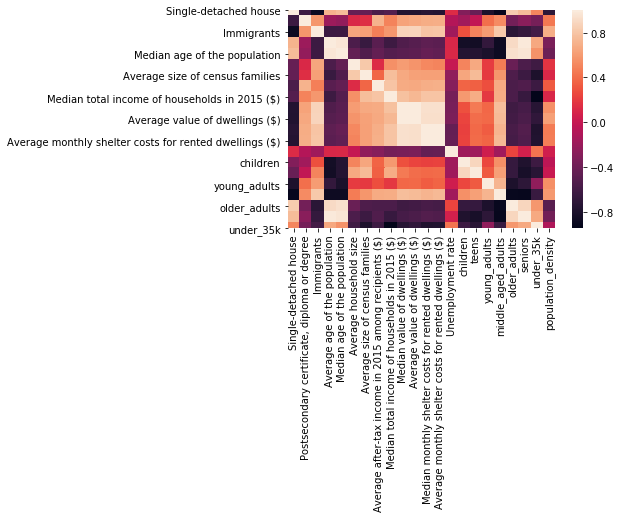

In [536]:
cor_mat = phu_census.corr()
sns.heatmap(cor_mat, annot = False)
plt.show()

Looking at the correlation matrix, we can see that there are a many highly correlated features. We can identify groups of highly correlated features and only include one feature from each group to create a dataset that is not multicollinear.

In [537]:
census_cols = phu_census.columns.values
census_cols

array(['Single-detached house',
       'Postsecondary certificate, diploma or degree', 'Immigrants',
       'Average age of the population', 'Median age of the population',
       'Average household size', 'Average size of census families',
       'Average after-tax income in 2015 among recipients ($)',
       'Median total income of households in 2015 ($)',
       'Median value of dwellings ($)', 'Average value of dwellings ($)',
       'Median monthly shelter costs for rented dwellings ($)',
       'Average monthly shelter costs for rented dwellings ($)',
       'Unemployment rate', 'children', 'teens', 'young_adults',
       'middle_aged_adults', 'older_adults', 'seniors', 'under_35k',
       'population_density'], dtype=object)

In [538]:
n = len(census_cols)

We create an undirected graph of column indices to see which features are highly correlated to eachother

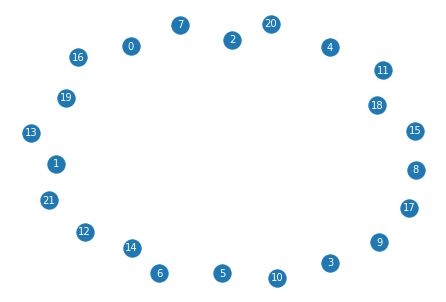

In [539]:
cor_graph = nx.Graph()
cor_graph.add_nodes_from(range(n))
nx.draw(cor_graph, with_labels=True, font_size= 10, font_color='white')

Now, we add edges between highly correlated edges (absolute value greater than 0.75)

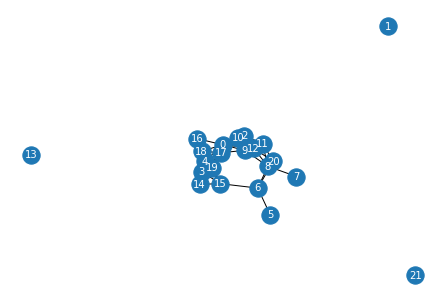

In [540]:
cor_list = [(i,j) for i in range(n) for j in range(i+1, n) if abs(cor_mat.loc[census_cols[i], census_cols[j]]) > 0.75]
cor_graph.add_edges_from(cor_list)
nx.draw(cor_graph, with_labels=True, font_size= 10, font_color='white')

Then, we find a maximum [independent set](https://en.wikipedia.org/wiki/Independent_set_(graph_theory) to find the features that are less correlated

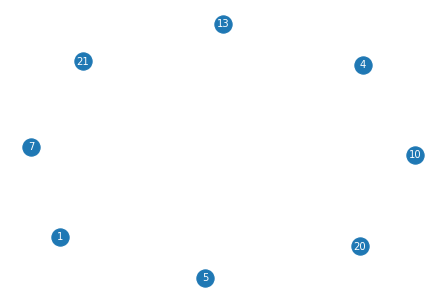

In [541]:
un_cor_nodes = nx.maximal_independent_set(cor_graph)
nx.draw(cor_graph.subgraph(un_cor_nodes),  with_labels=True, font_size= 10, font_color='white')

In [542]:
un_cor_census_cols = census_cols[un_cor_nodes]

Then, we can see that the features from the maximum indpendent set have absolute correlations  less than 0.75

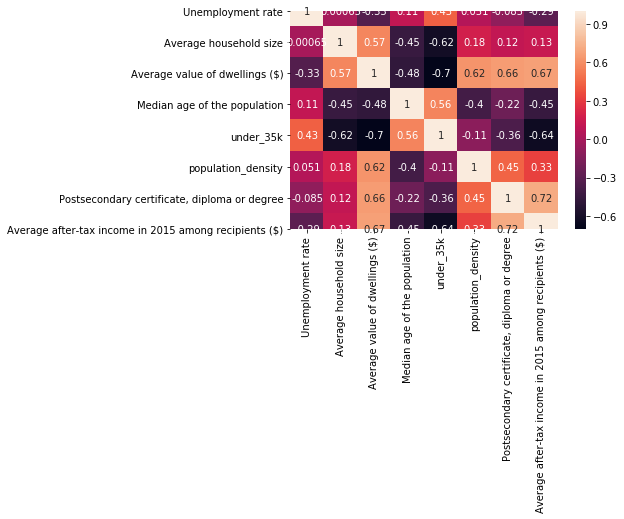

In [543]:
new_cor_mat = phu_census[un_cor_census_cols].corr()
sns.heatmap(new_cor_mat, annot = True)
plt.show()

Then, we create our final census PHU dataset from these features and add population 

In [544]:
un_cor_phu_census = phu_census[un_cor_census_cols]
un_cor_phu_census.head()

,Unemployment rate,Average household size,Average value of dwellings ($),Median age of the population,under_35k,population_density,"Postsecondary certificate, diploma or degree",Average after-tax income in 2015 among recipients ($)
PHU_ID,,,,,,,,
2226,10.050138,1.900958,208018.124548,47.722901,0.127892,2.319446,0.421755,34822.154128
2227,5.476935,1.991033,332674.215128,40.909740,0.088482,143.556383,0.387386,35741.995917
2230,7.651187,2.185298,502575.296071,40.063882,0.051242,256.396189,0.436726,40296.935231
2233,5.659991,2.000000,327514.518104,47.726462,0.101596,20.238022,0.418444,37556.877939
2234,6.584066,2.000000,313796.845365,45.752198,0.082807,38.366690,0.381160,35651.449385


### Getting Mean Daily Temperature By PHU
Since COVID-19 is considered to be a primarily air-borne virus, ventilation can greatly impact transmission. In Ontario, temperature can affect the amount of time people spend outside, which has better air-circulation compared to indoor settings. As a result, temperature could be a factor that impacts transmission.

Using BeatutifulSoup, we can scrape [Canada's climate website](http://climate.weather.gc.ca) to find all the Ontario weather stations that collect temperature.

In [181]:
def scrape_stations(province, start_year, end_year):
    now = dt.datetime.today()
    base_url = "http://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?"
    request_params = {'searchType': 'stnProv', 'timeframe': '1', 'optLimit': 'yearRange', 
                      'lstProvince': province, 'StartYear': start_year, 'EndYear': end_year,
                      'Year': now.year, 'Month': now.month, 'Day': now.day, 'selRowPerPage': 100,
                      'txtCentralLatMin': 0, 'txtCentralLatSec': 0}
    page_num = 0
    station_ids = set()
    while True:
        try:
            request_params['startRow'] = page_num * 100
            response = requests.get(base_url, params=request_params)
            page = BeautifulSoup(response.text, 'html.parser')
            station_forms = page.findAll("form", {"id" : re.compile('stnRequest*')})
            if len(station_forms) == 0:
                break
            for sf in station_forms:
                station_ids.add(sf.find("input", {"name" : "StationID"})['value']) 
        except ... as e:
            raise e
            print(f'Failed on page {page_num}')
            break
        page_num += 1
    return station_ids

In [183]:
station_ids = scrape_stations('ON', 2020, 2021)

In [221]:
def get_daily_temp(station_id, year):
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&timeframe=2".format(station_id, year)
    api_endpoint = base_url + query_url
    raw_data = pd.read_csv(api_endpoint, skiprows=0)
    mean_temp = raw_data.loc[:,['Date/Time','Longitude (x)', 'Latitude (y)', 'Mean Temp (°C)']]
    mean_temp['station_id'] = station_id
    return mean_temp

In [222]:
def get_temp_data(station_ids, start_year, end_year):
    df = pd.DataFrame()
    for station_id in station_ids:
        for year in [start_year + i for i in range(end_year - start_year + 1)]:
            df = df.append(get_daily_temp(station_id, year))
    return df

Then we pull daily temperature for all the Ontario weather stations for 2020 and 2021

In [223]:
temp_data = get_temp_data(station_ids, 2020, 2021)
temp_data.head()

,Date/Time,Longitude (x),Latitude (y),Mean Temp (°C),station_id
0,2020-01-01,-78.3,44.35,-3.3,43763
1,2020-01-02,-78.3,44.35,0.7,43763
2,2020-01-03,-78.3,44.35,3.3,43763
3,2020-01-04,-78.3,44.35,-0.6,43763
4,2020-01-05,-78.3,44.35,-2.9,43763


Getting station location

In [224]:
locations = temp_data.groupby('station_id')[['Longitude (x)', 'Latitude (y)']].max()
locations.head()

,Longitude (x),Latitude (y)
station_id,,
10197,-85.43,54.98
10220,-91.63,48.76
10244,-87.94,52.20
10899,-94.76,49.47
10903,-75.85,44.42


In [225]:
station_dict = locations.apply(lambda x: Point(x['Longitude (x)'], x['Latitude (y)']), axis=1).to_dict()

Mapping Station ID to Public Health Unit (PHU)

In [226]:
station_phu_dict = {}
station_set = set(station_dict.keys())
for phu_id, phu in phu_dict.items():
    for station_id in station_set.copy():
        point = station_dict[station_id]
        if point.within(phu):
            station_phu_dict[station_id] = phu_id
            station_set.remove(station_id)

In [227]:
def plot_phu_stations(phu_dict, station_dict, station_phu_dict):
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])
    cm = plt.get_cmap('RdBu')
    colour_dict = {phu_id: cm(1. * i / len(phu_dict)) for i, phu_id in enumerate(phu_dict.keys())}
    
    for phu_id, phu in phu_dict.items():
        if phu.geom_type == 'Polygon':
            geoms = [phu]
        else:
            geoms = phu.geoms
        for geom in geoms:
            xs, ys = geom.exterior.xy    
            ax.fill(xs, ys, alpha=0.5, fc=colour_dict[phu_id], ec='none')
    for station_id, phu_id in station_phu_dict.items():
        p = station_dict[station_id]
        ax.scatter(p.x, p.y, color = colour_dict[phu_id])
    plt.show()


Plotting weather stations in the same colour as their corresponding PHUs across ontario, we can see there there is good coverage across PHUs and that we have correclty mapped weather stations to PHU.

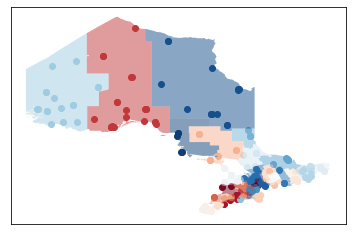

In [228]:
plot_phu_stations(phu_dict, station_dict, station_phu_dict)

Adding PHU to our temperature dataframe

In [229]:
temp_data = temp_data.merge(pd.DataFrame(station_phu_dict.items(), columns = ['station_id', 'PHU_ID']))
temp_data['date'] = pd.to_datetime(temp_data['Date/Time'])
temp_data = temp_data.set_index(['PHU_ID', 'date'])[['Mean Temp (°C)']]
temp_data.head()

Mean Temp (°C)
PHU_ID date                      
2255   2020-01-01            -3.3
       2020-01-02             0.7
       2020-01-03             3.3
       2020-01-04            -0.6
       2020-01-05            -2.9

Getting an average daily temperature for each PHU

In [230]:
temp_phu_data = temp_data.groupby(['PHU_ID','date']).mean()
temp_phu_data.head()

Mean Temp (°C)
PHU_ID date                      
2226   2020-01-01          -5.000
       2020-01-02          -0.675
       2020-01-03          -1.650
       2020-01-04          -4.725
       2020-01-05          -4.450

Getting a 7 day rolling average daily temperature

In [231]:
rolling_average_daily_temp_phu = temp_phu_data.reset_index().set_index('date').groupby('PHU_ID').rolling(7).mean().shift(-3)[['Mean Temp (°C)']].dropna()
rolling_average_daily_temp_phu.head()

Mean Temp (°C)
PHU_ID date                      
2226   2020-01-04       -4.235714
       2020-01-05       -5.760714
       2020-01-06       -6.992857
       2020-01-07       -6.889286
       2020-01-08       -7.700000

## Combining Datasets to Get One COVID-19 Ontario Dataset

In [1121]:
combined_features = phu_data.merge(rolling_average_daily_temp_phu, left_index=True, right_index=True).reset_index()
combined_features = combined_features.set_index('PHU_ID').merge(un_cor_phu_census, left_index=True, right_index=True)
combined_features.set_index('date', append=True, inplace=True)
combined_features.head()

PHU_NAME         state school  Control  Lockdown  \
PHU_ID date                                                                  
2226   2020-08-10  ALGOMA DISTRICT       Phase 3      0      0.0       0.0   
       2020-03-18  ALGOMA DISTRICT       Phase 0      0      0.0       0.0   
       2020-05-01  ALGOMA DISTRICT       Phase 0      0      0.0       0.0   
       2021-01-07  ALGOMA DISTRICT  Stay-at-home      0      0.0       0.0   
       2020-03-29  ALGOMA DISTRICT       Phase 0      0      0.0       0.0   

                   Other  Phase 0  Phase 1  Phase 2  Phase 3  ...  \
PHU_ID date                                                   ...   
2226   2020-08-10    0.0      0.0      0.0      0.0      1.0  ...   
       2020-03-18    0.0      1.0      0.0      0.0      0.0  ...   
       2020-05-01    0.0      1.0      0.0      0.0      0.0  ...   
       2021-01-07    0.0      0.0      0.0      0.0      0.0  ...   
       2020-03-29    0.0      1.0      0.0      0.0      0.0  ...   

                   Stay-at-home  Mean Temp (°C)  Unemployment rate  \
PHU_ID date                                                          
2226   2020-08-10           0.0       19.107143          10.050138   
       2020-03-18           0.0       -6.614286          10.050138   
       2020-05-01           0.0        5.214286          10.050138   
       2021-01-07           1.0       -4.732143          10.050138   
       2020-03-29           0.0        1.577381          10.050138   

                   Average household size  Average value of dwellings ($)  \
PHU_ID date                                                                 
2226   2020-08-10                1.900958                   208018.124548   
       2020-03-18                1.900958                   208018.124548   
       2020-05-01                1.900958                   208018.124548   
       2021-01-07                1.900958                   208018.124548   
       2020-03-29                1.900958                   208018.124548   

                   Median age of the population  under_35k  \
PHU_ID date                                                  
2226   2020-08-10                     47.722901   0.127892   
       2020-03-18                     47.722901   0.127892   
       2020-05-01                     47.722901   0.127892   
       2021-01-07                     47.722901   0.127892   
       2020-03-29                     47.722901   0.127892   

                   population_density  \
PHU_ID date                             
2226   2020-08-10            2.319446   
       2020-03-18            2.319446   
       2020-05-01            2.319446   
       2021-01-07            2.319446   
       2020-03-29            2.319446   

                   Postsecondary certificate, diploma or degree  \
PHU_ID date                                                       
2226   2020-08-10                                      0.421755   
       2020-03-18                                      0.421755   
       2020-05-01                                      0.421755   
       2021-01-07                                      0.421755   
       2020-03-29                                      0.421755   

                   Average after-tax income in 2015 among recipients ($)  
PHU_ID date                                                               
2226   2020-08-10                                       34822.154128      
       2020-03-18                                       34822.154128      
       2020-05-01                                       34822.154128      
       2021-01-07                                       34822.154128      
       2020-03-29                                       34822.154128      

[5 rows x 23 columns]

In [1122]:
combined = cases_by_phu_with_zeros.merge(combined_features, left_index=True, right_index=True)
combined.head()

,,new_cases,total_infectious,resolved_cases,PHU_NAME,state,school,Control,Lockdown,Other,Phase 0,...,Stay-at-home,Mean Temp (°C),Unemployment rate,Average household size,Average value of dwellings ($),Median age of the population,under_35k,population_density,"Postsecondary certificate, diploma or degree",Average after-tax income in 2015 among recipients ($)
PHU_ID,date,,,,,,,,,,,,,,,,,,,,,
2265,2021-01-15,62.063405,1216.454582,165.184138,WATERLOO REGION,Stay-at-home,0,0.0,0.0,0.0,0.0,...,1.0,-0.928571,5.641397,2.021041,393997.470465,37.724748,0.072914,391.767204,0.423719,38985.144130
2251,2020-09-27,94.512000,1040.860407,86.636000,CITY OF OTTAWA,Phase 3,1,0.0,0.0,0.0,0.0,...,0.0,16.833333,7.000000,2.000000,444589.000000,40.000000,0.069714,334.854122,0.519223,44428.000000
2265,2020-08-12,4.356216,28.635116,1.742486,WATERLOO REGION,Phase 3,0,0.0,0.0,0.0,0.0,...,0.0,21.742857,5.641397,2.021041,393997.470465,37.724748,0.072914,391.767204,0.423719,38985.144130
2241,2020-05-23,0.000000,1.855743,0.000000,"KINGSTON, FRONTENAC, LENNOX & ADDINGTON",Phase 1,0,0.0,0.0,0.0,0.0,...,0.0,17.357143,6.592125,2.000000,341144.451345,43.327323,0.094727,29.705891,0.463171,38330.692260
2244,2020-05-05,3.549916,40.776979,1.183305,MIDDLESEX-LONDON,Phase 0,0,0.0,0.0,0.0,1.0,...,0.0,7.180952,6.531118,1.999328,306014.930671,39.662965,0.103924,140.291346,0.453476,37236.497609


# Modelling COVID-19 Cases in Ontario

## Understanding the Dataset

Each row in the COVID-19 dataset represents a single day for a Public Health Unit (PHU). Like any regression problem, we want to know how the features of the dataset can be used to predict the response variable.

### Response Variable
The **response variable** is the **estimated number of new COVID-19 cases** that were **contracted**  on a specific date in a specific PHU. It's labelled as **'new_cases'**

### Features

The **features** of this dataset include **daily statistics** for each public health unit such as restrictions, whether schools are open, and mean daily temperature in the PHU. **PHU-specific census statistics** (that don't change day-to-day) are also features in this dataset to help identify the differences between PHU's.

## Modelling Approach
###  Infection Period COVID-19 Transmission vs. Daily COVID-19 Cases
It's very important to understand and be conscious of the difference between the distribution of infection period COVID-19 transmission (the total number of people that contract COVID-19 from one infected person) and the number of newly contracted COVID-19 cases on a specific date. For our modelling, we are trying to predict the latter (daily COVID-19 cases). While modelling the infection period transmission of a virus is very important for understanding the contagiousness of a virus, it requires incredible contract tracing ability to build a dataset because you would need to know exactly how many people each infected individual infected (there's no publicly available contact tracing data like this). Additionally, for the purposes of this project, we want to know the impact of public health restrictions and other factors on new cases, which is why it makes sense to predict new contracted cases on **a specific date** based on the public health restrictions and other factors associated with that date. 
### Plan
We need to 
1. Determine the **distribution of infection period COVID-19 transmission**: what distribution does the total number of people that contract COVID-19 from one infected person follow?
2. Determine the **distribution of daily COVID-19 transmission**: what distribution does the number of people that contract COVID-19 from one infected person on one day (when factors and restrictions can change day to day) follow?
3. Determine the **distribution of total daily COVID-19 contracted cases**: what distribution does the daily total number of people that contract COVID-19 from all infected individuals follow?
4. Determine regression model: based on the distributions in 1, 2, and 3, how can we run a regression to model this data?
5. Determine prediction strategy :based on the distributions in 1, 2, and 3, how can we predict/simulate future COVID-19 case spread in Ontario based on restrictions?

## 1. Distribution of COVID-19 Transmission over Infection Period
According to this [UK Research Paper](https://royalsociety.org/-/media/policy/projects/set-c/set-covid-19-R-estimates.pdf#page=12), the distribution of the number of people that contract COVID-19 from one infected person "is best described by the **negative binomial** probability model where the variance is typically much greater than the mean". In order to understand the intuition and math behind why COVID-19 transmission over the infection period follows a negative binomial distribution, it's important to understand the Poisson distribution.

### Poisson Distribution
The [poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution#:~:text=In%20probability%20theory%20and%20statistics,time%20or%20space%20if%20these) is a discrete distribution that models the probability a specific number of events occurs in a specific interval of time or space. A poisson random variable follows a constant mean rate that is equal to its variance; that is $\mu = \operatorname {E} (\mathbf {x}) = Var(\mathbf {x})$. An example of a Poisson random variable is the number of customers that visit a café from 1:00 PM to 2:00 PM. Intuitively, one might speculate that the COVID-19 transmission of an infected invidual over the infection period would follow a Poisson distribution, and that is partially true.

### Poisson-Gamma Mixture (Negative Binomial)
As outlined above, the Poisson distribution assumes a constant mean rate, however **not every** infected individual in the same conditions will **transmit** COVID-19 at the **same rate**. The Poisson-Gamma Mixture allows us to assume that an individual's transmission follows a Poisson distribution with a **mean rate that is a Gamma random variable**. Similar to the Poisson distribution, a Poisson-Gamma random variable has a **mean rate parameter $\mu$**, but it also has a **dispersion or aggregration parameter $\alpha$**. The mean and variance of a Poisson-Gamma random variable are $\mu = \operatorname {E} (\mathbf {x})$ and $Var(\mathbf {x}) = \mu + \alpha \mu^2$ respectively.

Consider the following scenario: we randomly select one of your friends and they contract COVID-19. Let $X$ be number of people that your friend infects with COVID-19 over their infection period. Assuming COVID-19 transmission over the infection period follows a Poisson-Gamma mixture, $X \sim \operatorname {Poisson-Gamma} (\mu, \alpha)$ where $\mu$ is the mean number of new infections per active infection in your friend's Public Health Unit based on current restrictions, and $\alpha$ is the dispersion or aggregation parameter, which represents the variation in behaviour and viral load across the population. Equivalently, $X \mid W \sim \operatorname {Poisson} (W)$ where $W \sim \operatorname {Gamma} (k, \theta)$ such that $\theta =\alpha \mu$ and $ k = \frac{1}{\alpha}$. Thinking about the Poisson-Gamma mixture as a compound distribution helps us understand why COVID-19 transmission over the infeciton period follows this distribution. For the sake of understanding, let $\mu = 1.1$ currently and let $\alpha = 3$. When we randomly select one of your friends to contract COVID-19, the random variable $W$ is realized (observed). For example, say we randomly sample your friend Gary (age 35), who disobeys public health restrictions and interacts with a lot of people, and happens to have a very large viral load ([associated with greater infectiousness](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0243597_)). Based on all these factors, $w$ (observed value of $W$) is to be 3.5. Then, the number of people he infects with COVID-19 over the infection period would then follow the conditional distribution $X \mid W = 3.5\sim \operatorname {Poisson} (3.5)$.

As it turns out, the Poisson-Gamma Mixture follows a **Negative Binomial distribution**. We can show this by deriving the probability mass function for a Poisson-Gamma random variable.

\begin{aligned}f_{Poisson-Gamma}(x;\mu,\alpha)&=\int _{0}^{\infty }f_{\operatorname {Poisson} (\lambda )}(x)\cdot f_{\operatorname {Gamma} \left(k,\,{\theta}\right)}(\lambda )\ \mathrm {d} \lambda  \quad \text{where} \quad \theta =\alpha \mu \quad \text{and} \quad k = \frac{1}{\alpha}
\\[8pt]&=\int _{0}^{\infty }{\frac {\lambda ^{x}}{x!}}e^{-\lambda }\cdot \lambda ^{k-1}{\frac {e^{- \frac {\lambda}{\theta}}}{\theta ^ {k}\,\Gamma (k)}}\; \mathrm {d} \lambda 
\\[8pt]&={\frac {\theta^{-k}}{x!\,\Gamma (k)}}\int _{0}^{\infty }\lambda ^{k+x-1}e^{-\lambda (\frac{\theta + 1}{\theta})}\; \mathrm {d} \lambda 
\\[8pt]&={\frac {\theta^{-k}\left(\frac{\theta}{\theta + 1}\right)^{k+x-1}}{x!\,\Gamma (k)}}\int _{0}^{\infty }\left(\frac{\theta + 1}{\theta}\right)^{k+x-1}\lambda ^{k+x-1}e^{-\lambda (\frac{\theta + 1}{\theta})}\; \mathrm {d} \lambda 
\\[8pt]&={\frac {\theta^{-k}\left(\frac{\theta}{\theta + 1}\right)^{k}\left(\frac{\theta}{\theta + 1}\right)^{x-1}}{x!\,\Gamma (k)}}\int _{0}^{\infty }\left(\lambda \left(\frac{\theta + 1}{\theta}\right)\right)^{k+x-1}e^{-\lambda (\frac{\theta + 1}{\theta})} \; \mathrm {d} \lambda 
\\[8pt]&={\frac {\left(\frac{1}{\theta + 1}\right)^{k}\left(\frac{\theta}{\theta + 1}\right)^{x-1}}{x!\,\Gamma (k)}}\int _{0}^{\infty }u^{k+x-1}e^{-u} \; \mathrm {d} \lambda  \quad \text{where} \quad  u = \lambda \left(\frac{\theta + 1}{\theta}\right)
\\[8pt]&={\frac {\left(\frac{1}{\theta + 1}\right)^{k}\left(\frac{\theta}{\theta + 1}\right)^{x}}{x!\,\Gamma (k)}}\int _{0}^{\infty }u^{k+x-1}e^{-u} \; \mathrm {d} u  \quad \text{since} \quad  \mathrm {d} u = \frac{\theta + 1}{\theta} {d} \lambda
\\[8pt]&={\frac {\left(\frac{1}{\theta + 1}\right)^{k}\left(\frac{\theta}{\theta + 1}\right)^{x}}{x!\,\Gamma (k)}}\Gamma (k+x) \quad \text{by the definition of the gamma function}
\\[8pt]&={\frac {\Gamma (\frac{1}{\alpha}+x)}{x!\,\Gamma (\frac{1}{\alpha})}} \cdot \left(\frac{1}{\alpha \mu + 1}\right)^{\frac{1}{\alpha}}\left(\frac{\alpha \mu}{\alpha \mu + 1}\right)^{x}
\end{aligned}

Which is the probability mass function of an $\operatorname {NB} \left(\frac{1}{\alpha}, \frac{\alpha \mu}{\alpha \mu + 1}\right)$ random variable. This makes sense as if $X \sim \operatorname {NB} (r, p)$, where $r=\frac{1}{\alpha}$ and $p =  \frac{\alpha \mu}{\alpha \mu + 1}$, $\implies \operatorname {E} (X) = {\frac {pr}{1-p}} 
= {\frac {\left(  \frac{\alpha \mu}{\alpha \mu + 1}\right) \left(\frac{1}{\alpha}\right)}{1-\frac{\alpha \mu}{\alpha \mu + 1}}} = {\frac {\mu}{(\alpha \mu + 1)-\alpha \mu}} = \mu$ and $\operatorname {Var} (X) = {\frac {pr}{(1-p)^2}}= \frac {\mu}{1-\frac{\alpha \mu}{\alpha \mu + 1}} = \mu (\alpha \mu + 1) = \mu + \alpha \mu^2$ as expected.

## 2. Distribution of Daily COVID-19 Transmission
Given that the distribution of COVID-19 transmission over the entire infection period follows a Negative Binomial distribution (which is equivalent to a Poisson-Gamma mixture distribution), we want to know the distribution of COVID-19 transmission for one day of the infection period. Above , we outlined that an infected individual's COVID-19 transmission over the infection period can be modelled by $X \sim \operatorname {Poisson-Gamma} (\mu, \alpha)$, or equivalently $X  \mid W \sim \operatorname {Poisson} (W)$ where $W \sim \operatorname {Gamma} (\frac{1}{\alpha}, \alpha \mu)$ with mean transmission rate $\mu$ and dispersion parameter $\alpha$. Let $Z \sim \operatorname {Gamma} (\frac{1}{\alpha}, \alpha)$. Then by the scaling property of the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution),  $ \mu Z \sim \operatorname {Gamma} (\frac{1}{\alpha}, \alpha \mu)$ where $\mu > 0$. Since $W \sim \operatorname {Gamma} (\frac{1}{\alpha}, \alpha \mu)$ and $ \mu Z \sim \operatorname {Gamma} (\frac{1}{\alpha}, \alpha \mu)$, $ \implies W = \mu Z$. As a result, $X  \mid Z\sim \operatorname {Poisson} (\mu Z)$. Since $\mu$ represents the mean number of people that an infected individual will infect over the entire infection period, we can represent $ \mu$ as the sum of daily transmission rates for each day in the infection period. That is $\mu = \sum_{i = 1}^{11} \mu_{i}$ where $\mu_{i}$ is the mean number of people that an infected individual will infect on the $i^{th}$ day in the infection period based on the restrictions and other factors affecting transmission that day (assuming constant infectiousness through an 11 day infectious period from 3 to 14 days after exposure). It follows that $X \mid Z \sim \operatorname {Poisson} (\mu Z) \sim \operatorname {Poisson} \left(\left(\sum_{i = 1}^{11} \mu_{i}\right)Z\right) \sim \operatorname {Poisson} \left(\sum_{i = 1}^{11}\left( \mu_{i}Z\right)\right)$. Then, [Raikov's Theorem](https://en.wikipedia.org/wiki/Raikov%27s_theorem#cite_ref-1) let's us represent $X$ as a sum of conditionally independent Poisson random variables. That is, $X = \sum_{i = 1}^{11} X_{i}$ such that $ X_{i} \mid Z \sim {Poisson} (\mu_{i} Z))$. As a result, an infected individual's COVID-19 transmission for individual days each follow a Poisson distribution conditional on the same Gamma random variable. Notice that each day is conditionally independent on $Z$, but not fully independent. 

### Estimation of Dispersion Parameter $\alpha$
Note that since this distribution depends on the dispersion parameter $\alpha$, it is very important that we find an appropriate estimate of $\alpha$. According to [this study in Georgia](https://www.pnas.org/content/117/36/22430), the estimated dispersion parameter k (where $k = \frac{1}{\alpha}$), is "0.45 for Cobb County, 0.43 for Dekalb, 0.39 for Fulton, 0.49 for Gwinnett, and 0.32 for Dougherty". Based on these estimates, an estimate of $k = 0.4 \implies \alpha = 2.5$ seems appropriate.


## 3. Distribution of Total Daily Contracted COVID-19 Cases
We now know the distribution of COVID-19 transmission of an infected individual over the entire infection period and daily, but we want to know the distribution of total daily contracted COVID-19 cases. That is, the sum of individual daily COVID-19 transmission across all infected individuals. Let $S_{m}$ be the set of $n_{m}$ individuals in a PHU who have COVID-19 and are contagious on day ${m}$. Let $\mu_{m}$ be the expected daily transmission on day $m$ (expected number of people that 1 infected individual will infect on day $m$), based on the public health restrictions and other factors on day $m$. Let $X_{m, j}$ be the number of people that infected individual $j$ infects on day $m$ $\forall j \in S_{m}$. Based on the derived distribution of daily COVID-19 transmission, we know that $X_{m, j} \mid Z_{j} \sim \operatorname {Poisson} (\mu_{m} Z_{j}))$ where $Z_{j} \sim \operatorname {Gamma} (\frac{1}{\alpha}, \alpha)$ $\forall j \in S_{m}$. Let $T_{m}$ be the total number of new infections on day $m$. By definition, $T_{m} = \sum \limits_{j \in S_{m}} X_{m, j}$. By the [sum of poisson property](https://en.wikipedia.org/wiki/Poisson_distribution#Sums_of_Poisson-distributed_random_variables), $ T_{m} \mid Z_{j} \forall j \in S_{m} \sim \operatorname {Poisson} \left(\sum \limits_{j \in S_{m}} \mu_{m}Z_{j}\right) \implies  T_{m} \mid \sum \limits_{j \in S_{m}} Z_{j} \sim \operatorname {Poisson} \left(\mu_{m} \left(\sum \limits_{j \in S_{m}} Z_{j}\right)\right) $$\implies  T_{m} \mid U_{m} \sim \operatorname {Poisson} \left(\mu_{m} U_{m}\right)$ where $U_{m} = \sum \limits_{j \in S_{m}} Z_{j} \implies U_{m} \sim \operatorname {Gamma} (\frac{n_{m}}{\alpha}, \alpha)  \sim  \operatorname {Gamma}  (\frac{n_{m}}{\alpha},\frac{\alpha}{n_{m}} (n_{m}))$ by the [sum of Gamma property](https://en.wikipedia.org/wiki/Gamma_distribution#Summation). Then, by the definition of the Poisson-Gamma mixture, $ T_{m} \sim \operatorname {Poisson-Gamma} (n_{m} \mu_{m}, \frac{\alpha}{n_{m}}) \sim \operatorname {NB} \left(\frac{n_{m}}{\alpha}, \frac{\alpha \mu}{\alpha \mu + 1}\right)$. Since the distribution of daily COVID-19 cases follows a Negative Binomial distribution, you might expect that it would be fairly straight forward to model with a Negative Binomial regression. However due to a lack of independence across days, and a changing dispersion parameter, modelling our dataset with a **Negative Binomial regression is infeasible**.

### Dependence Across Days
While the distribution of total daily contracted COVID-19 cases should follow a Negative Binomial distribution (equivalent to Poisson-Gamma mixture), days that are close to eachother are not independent. If $T_{m}$ is the number of new infections on day $m$ (as described above), $T_{m}$ is not independent from $T_{m+1}$. This is because there will be a large overlap between the set of infectious individuals on day $m$, $S_{m}$, and the set of infectious individuals on day $m+1$, $S_{m + 1}$. While infected individuals who recover (or die) on day $m+1$ will be in $S_{m}$ and not $S_{m+1}$, and infected individuals that become contagious on day $m+1$ will be in $S_{m+1}$ and not $S_{m}$, most individuals in $S_{m}$ will be in $S_{m+1}$. Above, we showed that he total daily contracted COVID-19 cases is conditionally distributed such that $T_{m} \mid U_{m} \sim \operatorname {Poisson} \left(\mu_{m} U_{m}\right)$ where $U_{m} = \sum \limits_{j \in S_{m}} Z_{j}$ where $Z_{j} \sim \operatorname {Gamma} (\frac{1}{\alpha}, \alpha)$ $\forall j \in S_{m}$. As a result, $T_{m}$ depends on $Z_{j} \forall {j \in S_{m}}$ and $T_{m+1}$ depends on $Z_{j} \forall {j \in S_{m+1}}$, so they both depend on $Z_{j} \forall {j \in  S_{m}\cap S_{m+1}}$, and hence are not independent. Given the great amount of dependence that exists between contracted COVID-19 cases across days, modelling with a Negative Binomial distribution and assuming independence would vastly overestimate the amount of variance that should exist.

### Changing Dispersion Parameter Across Days
Above we showed that $ T_{m} \sim \operatorname {Poisson-Gamma} (n_{m} \mu_{m}, \frac{\alpha}{n_{m}})$ with mean $n_{m} \mu_{m}$ and dispersion parameter $\frac{\alpha}{n_{m}}$. Since the dispersion parameter depends on the number of infected individuals who are contagious on day $m$, $n_{m}$, this dispersion parameter will change day-to-day (row-to-row in our dataset). Unfortunately, Negative Binomial regression assumes a constant dispersion parameter.

## 4. Modelling Transmission Rates with Poisson Approximation
As outlined above, the reason why COVID-19 transmission does not follow the Poisson distribution is because **not every** infected individual in the same conditions will **transmit** COVID-19 at the **same rate**. The Poisson-Gamma mixture (equivalent to Negative Binomial) not only makes sense for modelling COVID-19 transmission inuitively and based on empirical studies, but fundamentally is a generalization of the Poisson distribution that can better fit and predict count data with variance higher than mean. This is becuase a Poisson distribution has $\mu = \operatorname {E} (\mathbf {x}) = Var(\mathbf {x})$ whereas a Poisson-Gamma distribution has $\mu = \operatorname {E} (\mathbf {x})$ and $Var(\mathbf {x}) = \mu + \alpha \mu^2$. Using a Poisson regression to model daily COVID-19 transmission will more heavily penalize outliers as it will use a Poisson variance-based cost function on a dataset with higher variance, but since it both heavily penalize higher and lower outliers, it should give accurate estimates of mean transmission rates, despite appearing to have a poor log-likelihood.

In [1123]:
regression_data = combined.loc[combined.total_infectious > 0].reset_index()
regression_data.set_index('date', inplace=True)
regression_data.head()

,PHU_ID,new_cases,total_infectious,resolved_cases,PHU_NAME,state,school,Control,Lockdown,Other,...,Stay-at-home,Mean Temp (°C),Unemployment rate,Average household size,Average value of dwellings ($),Median age of the population,under_35k,population_density,"Postsecondary certificate, diploma or degree",Average after-tax income in 2015 among recipients ($)
date,,,,,,,,,,,,,,,,,,,,,
2021-01-15,2265,62.063405,1216.454582,165.184138,WATERLOO REGION,Stay-at-home,0,0.0,0.0,0.0,...,1.0,-0.928571,5.641397,2.021041,393997.470465,37.724748,0.072914,391.767204,0.423719,38985.144130
2020-09-27,2251,94.512000,1040.860407,86.636000,CITY OF OTTAWA,Phase 3,1,0.0,0.0,0.0,...,0.0,16.833333,7.000000,2.000000,444589.000000,40.000000,0.069714,334.854122,0.519223,44428.000000
2020-08-12,2265,4.356216,28.635116,1.742486,WATERLOO REGION,Phase 3,0,0.0,0.0,0.0,...,0.0,21.742857,5.641397,2.021041,393997.470465,37.724748,0.072914,391.767204,0.423719,38985.144130
2020-05-23,2241,0.000000,1.855743,0.000000,"KINGSTON, FRONTENAC, LENNOX & ADDINGTON",Phase 1,0,0.0,0.0,0.0,...,0.0,17.357143,6.592125,2.000000,341144.451345,43.327323,0.094727,29.705891,0.463171,38330.692260
2020-05-05,2244,3.549916,40.776979,1.183305,MIDDLESEX-LONDON,Phase 0,0,0.0,0.0,0.0,...,0.0,7.180952,6.531118,1.999328,306014.930671,39.662965,0.103924,140.291346,0.453476,37236.497609


In [1124]:
train_dates, test_dates = train_test_split(regression_data.index.unique(), test_size=0.2)

In [1125]:
train_data = regression_data.loc[train_dates]
test_data = regression_data.loc[test_dates]

In [1126]:
def run_regression(train_data, y_col, w_col, x_cols):
    y_train = train_data[y_col]
    w_train = train_data[w_col]
    x_train = train_data[x_cols]
    X_train = sm.add_constant(x_train)
    return sm.GLM(y_train, X_train.astype(float), 
               exposure=w_train.astype(float), 
               family=sm.families.Poisson()).fit()

In [1133]:
exog_cols = ['school', 'Control', 'Lockdown', 'Other', 'Phase 0', 'Phase 1',
       'Phase 2', 'Phase 3', 'Prevent', 'Protect', 'Restrict', 'Stay-at-home',
       'Mean Temp (°C)', 'Unemployment rate', 'Average household size',
       'Average value of dwellings ($)', 'Median age of the population',
       'under_35k', 'population_density',
       'Postsecondary certificate, diploma or degree',
       'Average after-tax income in 2015 among recipients ($)']

In [1134]:
model = run_regression(train_data, 'new_cases', 'total_infectious', exog_cols)

In [1135]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              new_cases   No. Observations:                 9000
Model:                            GLM   Df Residuals:                     8979
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27416.
Date:                Fri, 07 May 2021   Deviance:                       28346.
Time:                        17:46:39   Pearson chi2:                 2.74e+17
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                    -2.0190      0.115    -17.500      0.000      -2.245      -1.793
school                                                   -0.1012      0.008    -13.301      0.000      -0.116      -0.086
Control                                                  -0.1488      0.012    -12.536      0.000      -0.172      -0.126
Lockdown                                                 -0.2367      0.012    -18.989      0.000      -0.261      -0.212
Other                                                    -0.2098      0.023     -9.283      0.000      -0.254      -0.165
Phase 0                                                  -0.3080      0.014    -22.766      0.000      -0.335      -0.282
Phase 1                                                  -0.4278      0.016    -26.077      0.000      -0.460      -0.396
Phase 2                                                  -0.0888      0.013     -6.651      0.000      -0.115      -0.063
Phase 3                                                   0.0302      0.013      2.266      0.023       0.004       0.056
Prevent                                                  -0.0264      0.029     -0.911      0.362      -0.083       0.030
Protect                                                  -0.0465      0.018     -2.524      0.012      -0.083      -0.010
Restrict                                                 -0.0396      0.015     -2.711      0.007      -0.068      -0.011
Stay-at-home                                             -0.5167      0.013    -38.467      0.000      -0.543      -0.490
Mean Temp (°C)                                           -0.0078      0.001    -15.462      0.000      -0.009      -0.007
Unemployment rate                                         0.0047      0.004      1.072      0.284      -0.004       0.013
Average household size                                    0.0532      0.023      2.359      0.018       0.009       0.097
Average value of dwellings ($)                         2.935e-09   4.35e-08      0.067      0.946   -8.23e-08    8.82e-08
Median age of the population                             -0.0028      0.002     -1.673      0.094      -0.006       0.000
under_35k                                                 0.7229      0.352      2.054      0.040       0.033       1.413
population_density                                     1.158e-05   5.94e-06      1.948      0.051   -6.87e-08    2.32e-05
Postsecondary certificate, diploma or degree             -0.3279      0.162     -2.019      0.043      -0.646      -0.010
Average after-tax income in 2015 among recipients ($)  9.315e-07   2.19e-06      0.425      0.671   -3.36e-06    5.22e-06
=================================

Removing features with high p-values

In [1139]:
exog_cols = [col for col in  exog_cols if col not in ['Prevent', 'Average value of dwellings ($)', 'Average after-tax income in 2015 among recipients ($)']]

In [1140]:
model = run_regression(train_data, 'new_cases', 'total_infectious', exog_cols)

In [1141]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              new_cases   No. Observations:                 9000
Model:                            GLM   Df Residuals:                     8981
Model Family:                 Poisson   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27416.
Date:                Fri, 07 May 2021   Deviance:                       28346.
Time:                        17:48:27   Pearson chi2:                 2.75e+17
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                           -2.0163      0.094    -21.487      0.000      -2.200      -1.832
school                                          -0.1013      0.008    -13.316      0.000      -0.116      -0.086
Control                                         -0.1225      0.028     -4.301      0.000      -0.178      -0.067
Lockdown                                        -0.2107      0.029     -7.379      0.000      -0.267      -0.155
Other                                           -0.1836      0.035     -5.232      0.000      -0.252      -0.115
Phase 0                                         -0.2821      0.030     -9.521      0.000      -0.340      -0.224
Phase 1                                         -0.4016      0.031    -12.849      0.000      -0.463      -0.340
Phase 2                                         -0.0627      0.029     -2.157      0.031      -0.120      -0.006
Phase 3                                          0.0564      0.029      1.948      0.051      -0.000       0.113
Protect                                         -0.0201      0.032     -0.632      0.527      -0.082       0.042
Restrict                                        -0.0142      0.029     -0.484      0.629      -0.072       0.043
Stay-at-home                                    -0.4907      0.029    -16.679      0.000      -0.548      -0.433
Mean Temp (°C)                                  -0.0078      0.001    -15.586      0.000      -0.009      -0.007
Unemployment rate                                0.0037      0.003      1.242      0.214      -0.002       0.009
Average household size                           0.0473      0.011      4.128      0.000       0.025       0.070
Median age of the population                    -0.0026      0.001     -1.795      0.073      -0.005       0.000
under_35k                                        0.6070      0.245      2.478      0.013       0.127       1.087
population_density                            1.253e-05   2.98e-06      4.200      0.000    6.68e-06    1.84e-05
Postsecondary certificate, diploma or degree    -0.2659      0.090     -2.953      0.003      -0.442      -0.089
================================================================================================================
"""

In [1142]:
def predict(test_data, model, y_col, w_col, x_cols):
    y_test = test_data[y_col]
    w_test = test_data[w_col]
    x_test = test_data[x_cols]
    X_test = sm.add_constant(x_test)
    return model.predict(X_test.astype(float), 
               exposure=w_test.astype(float))

In [1143]:
y_test = test_data['new_cases'].reset_index().groupby('date').sum()['new_cases']

In [1144]:
y_pred = predict(test_data, model, 'new_cases', 'total_infectious', exog_cols).reset_index().groupby('date').sum()['total_infectious']

In [1145]:
y_expected = test_data.total_infectious.reset_index().groupby('date').sum()['total_infectious']

In [1146]:
abs_error = abs(y_test - y_pred)
abs_error.sum() / y_test.sum()

0.1511212877915298

## 5. Predicting/Simulating COVID-19 Cases With Poisson-Gamma/Negative Binomial Distribution

Using the Poisson regression model to predict mean transmission rate, and the poisson-gamma/negative binomial distribution outlined above, we can simulate COVID-19 cases based on public health restrictions.

In [1147]:
def phu_predict(phu_cases, simulations, alpha):
    phu_cases.reset_index(drop=True, inplace=True)
    phu_cases.sort_values('date', inplace=True)
    predictions = phu_cases[['date']]
    for p in range(simulations):
        for i in range(1, len(phu_cases)):
            j = i + 3
            k = i + 14
            total_infectious = max(0.1, phu_cases.loc[i - 1, 'total_infectious'] + phu_cases.loc[i, 'new_infectious'] - phu_cases.loc[i, 'resolved_cases'])
            expected_new_cases = total_infectious * phu_cases.loc[i, 'pred_rate']
            try:
                new_cases = np.random.poisson(expected_new_cases)
            except:
                new_cases = 0
            phu_cases.loc[i, 'new_cases'] = new_cases
            phu_cases.loc[i, 'total_infectious'] = total_infectious
            
            new_mean = np.random.gamma(new_cases / alpha, alpha)
            
            if j < len(phu_cases):
                phu_cases.loc[j, 'new_infectious'] = new_mean
            if k < len(phu_cases):
                phu_cases.loc[k, 'resolved_cases'] = new_mean
        predictions[f'predict_new_cases_{p}'] = phu_cases['new_cases']
    
    predictions.set_index('date', inplace=True)
    
    return predictions

In [1148]:
def simulate(start_date, num_days, simulations, restrictions_dict, school_dict, alpha):
    future_dates = pd.DataFrame({'date': [start_date + dt.timedelta(i) for i in range(1, num_days)]}).set_index('date')
    future_data = pd.DataFrame({'PHU_ID': phu_ids}).groupby('PHU_ID').apply(lambda x: future_dates)
    future_data = future_data.merge(rolling_average_daily_temp_phu, left_index=True, right_index=True).reset_index()
    future_data = future_data.set_index('PHU_ID').merge(un_cor_phu_census, left_index=True, right_index=True)
    
    for col in  ['school', 'Control', 'Lockdown', 'Other', 'Phase 0', 'Phase 1',
       'Phase 2', 'Phase 3', 'Prevent', 'Protect', 'Restrict', 'Stay-at-home']:
        future_data[col] = 0
    for phu_id, state in restrictions_dict.items():
        future_data.loc[phu_id, state] = 1
    for phu_id, school in school_dict.items():
        future_data.loc[phu_id, 'school'] = school
    
    future_data.set_index('date', append=True, inplace=True)
    
    future_data['pred_rate'] = model.predict(sm.add_constant(future_data[exog_cols], has_constant='add'))
    
    combined_cases = combined.loc[:, ['new_cases', 'total_infectious']].sort_index()
    
    future_cases = future_data[['pred_rate']].merge(combined_cases, how='outer', left_index=True, right_index=True)
    future_cases.loc[:,'new_infectious'] = np.random.gamma( future_cases.loc[:, 'new_cases'].groupby('PHU_ID').shift(3) / alpha, alpha)
    future_cases.loc[:, 'resolved_cases'] = future_cases.loc[:, 'new_infectious'].groupby('PHU_ID').shift(11)
    future_cases = future_cases.loc[future_cases.pred_rate.notna()]
    
    return future_cases.reset_index().groupby('PHU_ID').apply(lambda x: phu_predict(x[['date', 'pred_rate', 'new_cases', 'total_infectious', 'resolved_cases', 'new_infectious']], simulations, alpha))

In [1149]:
def graph_predictions(df, scatter = False, legend=True):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1) 
    for col in df.columns:
        if scatter:
            plt.plot(df[col], 'o', label = col)
        else:
            plt.plot(df[col], label = col)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) 
    if legend:
        ax.legend()
    plt.show()

Here, we simulate COVID-19 cases from February 24th, 2021 if the 'Stay-at-home' public health restrictions state is in place for 80 days.

In [1150]:
predictions_1 = simulate(dt.datetime(2021, 2, 24), 80, 100, {phu_id: 'Stay-at-home' for phu_id in phu_ids}, {phu_id: 0 for phu_id in phu_ids}, 2.5)

In [1151]:
ontario_wide_predictions_1 = predictions_1.reset_index().groupby('date')[[f'predict_new_cases_{i}' for i in range(100)]].sum()
ontario_wide_predictions_1.head()

,predict_new_cases_0,predict_new_cases_1,predict_new_cases_2,predict_new_cases_3,predict_new_cases_4,predict_new_cases_5,predict_new_cases_6,predict_new_cases_7,predict_new_cases_8,predict_new_cases_9,...,predict_new_cases_90,predict_new_cases_91,predict_new_cases_92,predict_new_cases_93,predict_new_cases_94,predict_new_cases_95,predict_new_cases_96,predict_new_cases_97,predict_new_cases_98,predict_new_cases_99
date,,,,,,,,,,,,,,,,,,,,,
2021-02-25,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,...,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416
2021-02-26,865.000000,847.000000,861.000000,866.000000,885.000000,954.000000,849.000000,887.000000,889.000000,913.000000,...,838.000000,923.000000,876.000000,918.000000,851.000000,929.000000,906.000000,900.000000,966.000000,844.000000
2021-02-27,910.000000,863.000000,914.000000,872.000000,876.000000,842.000000,869.000000,834.000000,887.000000,858.000000,...,860.000000,894.000000,932.000000,867.000000,886.000000,852.000000,837.000000,892.000000,880.000000,803.000000
2021-02-28,841.000000,788.000000,881.000000,843.000000,835.000000,845.000000,880.000000,800.000000,834.000000,891.000000,...,859.000000,878.000000,834.000000,863.000000,880.000000,847.000000,858.000000,835.000000,805.000000,863.000000
2021-03-01,845.000000,837.000000,847.000000,791.000000,844.000000,824.000000,819.000000,837.000000,819.000000,830.000000,...,870.000000,830.000000,831.000000,812.000000,834.000000,875.000000,807.000000,882.000000,818.000000,824.000000


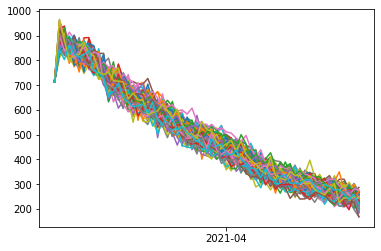

In [1152]:
graph_predictions(ontario_wide_predictions_1, False, False)

In [1153]:
min_pred = ontario_wide_predictions_1.min(axis=1)
max_pred = ontario_wide_predictions_1.max(axis=1)
median = ontario_wide_predictions_1.median(axis=1)
ontario_wide_predictions_1['min_pred'] = min_pred
ontario_wide_predictions_1['max_pred'] = max_pred
ontario_wide_predictions_1['median'] = median
ontario_wide_predictions_1.head()

,predict_new_cases_0,predict_new_cases_1,predict_new_cases_2,predict_new_cases_3,predict_new_cases_4,predict_new_cases_5,predict_new_cases_6,predict_new_cases_7,predict_new_cases_8,predict_new_cases_9,...,predict_new_cases_93,predict_new_cases_94,predict_new_cases_95,predict_new_cases_96,predict_new_cases_97,predict_new_cases_98,predict_new_cases_99,min_pred,max_pred,median
date,,,,,,,,,,,,,,,,,,,,,
2021-02-25,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,...,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416
2021-02-26,865.000000,847.000000,861.000000,866.000000,885.000000,954.000000,849.000000,887.000000,889.000000,913.000000,...,918.000000,851.000000,929.000000,906.000000,900.000000,966.000000,844.000000,811.000000,966.000000,886.000000
2021-02-27,910.000000,863.000000,914.000000,872.000000,876.000000,842.000000,869.000000,834.000000,887.000000,858.000000,...,867.000000,886.000000,852.000000,837.000000,892.000000,880.000000,803.000000,803.000000,938.000000,872.500000
2021-02-28,841.000000,788.000000,881.000000,843.000000,835.000000,845.000000,880.000000,800.000000,834.000000,891.000000,...,863.000000,880.000000,847.000000,858.000000,835.000000,805.000000,863.000000,788.000000,914.000000,849.500000
2021-03-01,845.000000,837.000000,847.000000,791.000000,844.000000,824.000000,819.000000,837.000000,819.000000,830.000000,...,812.000000,834.000000,875.000000,807.000000,882.000000,818.000000,824.000000,774.000000,902.000000,833.500000


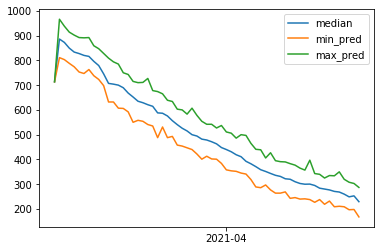

In [1154]:
graph_predictions(ontario_wide_predictions_1[['median', 'min_pred', 'max_pred']])

Here, we simulate COVID-19 cases from February 24th, 2021 if the 'Prevent' public health restrictions state is in place for 80 days.

In [1155]:
predictions_2 = simulate(dt.datetime(2021,2,24), 80, 100, {phu_id: 'Prevent' for phu_id in phu_ids}, {phu_id: 0 for phu_id in phu_ids}, 2.5)

In [1156]:
ontario_wide_predictions_2 = predictions_2.reset_index().groupby('date')[[f'predict_new_cases_{i}' for i in range(100)]].sum()
ontario_wide_predictions_2.head()

,predict_new_cases_0,predict_new_cases_1,predict_new_cases_2,predict_new_cases_3,predict_new_cases_4,predict_new_cases_5,predict_new_cases_6,predict_new_cases_7,predict_new_cases_8,predict_new_cases_9,...,predict_new_cases_90,predict_new_cases_91,predict_new_cases_92,predict_new_cases_93,predict_new_cases_94,predict_new_cases_95,predict_new_cases_96,predict_new_cases_97,predict_new_cases_98,predict_new_cases_99
date,,,,,,,,,,,,,,,,,,,,,
2021-02-25,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,...,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416
2021-02-26,1437.000000,1462.000000,1417.000000,1480.000000,1497.000000,1496.000000,1461.000000,1439.000000,1489.000000,1438.000000,...,1416.000000,1497.000000,1474.000000,1467.000000,1497.000000,1488.000000,1392.000000,1485.000000,1393.000000,1491.000000
2021-02-27,1414.000000,1438.000000,1420.000000,1443.000000,1420.000000,1447.000000,1467.000000,1368.000000,1460.000000,1439.000000,...,1425.000000,1501.000000,1420.000000,1376.000000,1506.000000,1477.000000,1470.000000,1438.000000,1470.000000,1459.000000
2021-02-28,1446.000000,1438.000000,1373.000000,1485.000000,1413.000000,1329.000000,1423.000000,1404.000000,1421.000000,1432.000000,...,1378.000000,1467.000000,1386.000000,1416.000000,1382.000000,1376.000000,1392.000000,1366.000000,1443.000000,1418.000000
2021-03-01,1538.000000,1483.000000,1486.000000,1447.000000,1435.000000,1447.000000,1530.000000,1481.000000,1401.000000,1500.000000,...,1491.000000,1456.000000,1474.000000,1437.000000,1464.000000,1477.000000,1480.000000,1559.000000,1461.000000,1505.000000


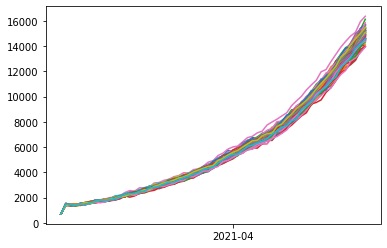

In [1157]:
graph_predictions(ontario_wide_predictions_2, False, False)

In [1158]:
min_pred = ontario_wide_predictions_2.min(axis=1)
max_pred = ontario_wide_predictions_2.max(axis=1)
median = ontario_wide_predictions_2.median(axis=1)
ontario_wide_predictions_2['min_pred'] = min_pred
ontario_wide_predictions_2['max_pred'] = max_pred
ontario_wide_predictions_2['median'] = median
ontario_wide_predictions_2.head()

,predict_new_cases_0,predict_new_cases_1,predict_new_cases_2,predict_new_cases_3,predict_new_cases_4,predict_new_cases_5,predict_new_cases_6,predict_new_cases_7,predict_new_cases_8,predict_new_cases_9,...,predict_new_cases_93,predict_new_cases_94,predict_new_cases_95,predict_new_cases_96,predict_new_cases_97,predict_new_cases_98,predict_new_cases_99,min_pred,max_pred,median
date,,,,,,,,,,,,,,,,,,,,,
2021-02-25,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,...,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416,713.453416
2021-02-26,1437.000000,1462.000000,1417.000000,1480.000000,1497.000000,1496.000000,1461.000000,1439.000000,1489.000000,1438.000000,...,1467.000000,1497.000000,1488.000000,1392.000000,1485.000000,1393.000000,1491.000000,1380.000000,1561.000000,1469.500000
2021-02-27,1414.000000,1438.000000,1420.000000,1443.000000,1420.000000,1447.000000,1467.000000,1368.000000,1460.000000,1439.000000,...,1376.000000,1506.000000,1477.000000,1470.000000,1438.000000,1470.000000,1459.000000,1361.000000,1516.000000,1435.000000
2021-02-28,1446.000000,1438.000000,1373.000000,1485.000000,1413.000000,1329.000000,1423.000000,1404.000000,1421.000000,1432.000000,...,1416.000000,1382.000000,1376.000000,1392.000000,1366.000000,1443.000000,1418.000000,1322.000000,1511.000000,1417.500000
2021-03-01,1538.000000,1483.000000,1486.000000,1447.000000,1435.000000,1447.000000,1530.000000,1481.000000,1401.000000,1500.000000,...,1437.000000,1464.000000,1477.000000,1480.000000,1559.000000,1461.000000,1505.000000,1385.000000,1572.000000,1480.500000


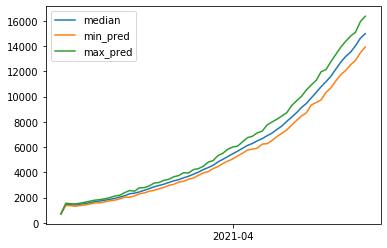

In [1159]:
graph_predictions(ontario_wide_predictions_2[['median', 'min_pred', 'max_pred']])